## Visualisation tools

In [712]:
from map_dm_nav.visualisation_tools import plot_likelihood
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import colors
from map_dm_nav.model.modules import from_degree_to_point


In [713]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_transitions(B: np.ndarray, state_map: dict, actions: dict) -> np.ndarray:
    """Plot Transitions matrix showing the probability of a transition between two states given a certain action."""
    
    sorted_state_map = dict(sorted(state_map.items(), key=lambda item: item[1]['state']))
    labels = [f"{key} ({value['state']})" for key, value in sorted_state_map.items()]

    n_actions = len(actions)
    l = int(np.ceil(np.sqrt(n_actions)))
    L = int(np.ceil(n_actions / l))
    
    fig, axes = plt.subplots(L, l, figsize=(L*3 + max(10, 2.5*len(state_map)), 
                                             l*2 + max(10, 1.5*len(state_map))))
    
    axes = np.atleast_2d(axes)  # Ensure axes is always a 2D array
    count = 0

    for i in range(L):
        for j in range(l):
            if count >= n_actions:
                fig.delaxes(axes[i][j])
                continue
            
            if count not in actions:
                continue

            action_str = str(actions[count])  # Convert action name to string

            # Plot the heatmap
            g = sns.heatmap(B[:len(labels), :len(labels), count], cmap="OrRd", linewidth=3, 
                            cbar=False, ax=axes[i, j], xticklabels=labels, yticklabels=labels)

            g.tick_params(axis='both', which='major', labelsize=14)  # Adjust label font size
            g.set_title(action_str, fontsize=20)
            g.set_xlabel('Prev State', fontsize=16)
            g.set_ylabel('Next State', fontsize=16)

            # Rotate labels for better visibility
            g.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
            g.set_yticklabels(labels, rotation=0, fontsize=12)
            
            count += 1

    plt.subplots_adjust(left=0.2, bottom=0.2)  # Add margin space
    plt.tight_layout()

    return fig


In [714]:
def compare_B1_B2_plots(B1: np.ndarray, B2: np.ndarray, state_map: dict, actions: dict) -> np.ndarray:
    """Plot Transitions matrix showing the probability of a transition between two states given a certain action.
       Common values in B1 and B2 (within a margin of 0.1) are set to 0 in the resulting B.
    """
    
    # Create B by zeroing out common values within margin 0.1
    margin = 0.1
    B = np.where(np.abs(B1 - B2) <= margin,0, B2)
    
    sorted_state_map = dict(sorted(state_map.items(), key=lambda item: item[1]['state']))
    labels = [f"{key} ({value['state']})" for key, value in sorted_state_map.items()]

    n_actions = len(actions)
    l = int(np.ceil(np.sqrt(n_actions)))
    L = int(np.ceil(n_actions / l))
    
    fig, axes = plt.subplots(L, l, figsize=(L*3 + max(10, 2.5*len(state_map)), 
                                             l*2 + max(10, 1.5*len(state_map))))
    
    axes = np.atleast_2d(axes)  # Ensure axes is always a 2D array
    count = 0

    for i in range(L):
        for j in range(l):
            if count >= n_actions:
                fig.delaxes(axes[i][j])
                continue
            
            if count not in actions:
                continue

            action_str = str(actions[count])  # Convert action name to string

            # Plot the heatmap
            g = sns.heatmap(B[:len(labels), :len(labels), count], cmap="OrRd", linewidth=3, 
                            cbar=False, ax=axes[i, j], xticklabels=labels, yticklabels=labels)

            g.tick_params(axis='both', which='major', labelsize=14)  # Adjust label font size
            g.set_title(action_str, fontsize=20)
            g.set_xlabel('Prev State', fontsize=16)
            g.set_ylabel('Next State', fontsize=16)

            # Rotate labels for better visibility
            g.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
            g.set_yticklabels(labels, rotation=0, fontsize=12)
            
            count += 1

    plt.subplots_adjust(left=0.2, bottom=0.2)  # Add margin space
    plt.tight_layout()

    return fig, B

In [715]:
def plot_state_in_map(B: np.ndarray, state_mapping: dict,fig_ax=[None, None]) -> np.ndarray:
    """
    Plot states as dots positioned based on `state_mapping` keys.
    Draw transitions between states based on transition probabilities in `B`.

    Parameters:
    - B (np.ndarray): Transition matrix of shape (num_states, num_states, num_actions).
    - state_mapping (dict): Mapping of (x, y) positions to state properties.
    - possible_actions (dict): Dictionary of action indices to angle ranges.
    - pose_dist (float): Distance associated with each move action.

    Returns:
    - fig (matplotlib Figure): The generated figure.
    """
    if fig_ax[0] is None:
        fig, ax = plt.subplots(figsize=(25, 25))
    else:
        fig = fig_ax[0]
        ax = fig_ax[1]


    # Get unique observation values for color mapping
    unique_obs = np.sort(list({v['ob'] for v in state_mapping.values()}))
    color_map = get_cmap() #get_cmap('viridis', len(unique_obs))
    ob_to_color = {ob: color_map.colors[i] for i, ob in enumerate(unique_obs)}

    # Draw transitions between states
    num_states, _, num_actions = B.shape
    for prev_state in range(num_states):
        for next_state in range(num_states):
            for action in range(num_actions):
                prob = B[next_state, prev_state, action]
                if prob > 0.1:  # Only plot meaningful transitions
                    # Find corresponding positions in `state_mapping`
                    prev_pos = next((pos for pos, data in state_mapping.items() if data['state'] == prev_state), None)
                    next_pos = next((pos for pos, data in state_mapping.items() if data['state'] == next_state), None)
                    
                    if prev_pos and next_pos:
                        ax.plot([prev_pos[1], next_pos[1]], [prev_pos[0], next_pos[0]], 
                                'k-', linewidth=prob * 10)  # Scale linewidth with probability

    # Plot states as dots
    for (x, y), data in state_mapping.items():
        state = data['state']
        ob = data.get('ob', 0)
        color = ob_to_color[ob]

        ax.plot(y, x, 'o', color=color, markersize=20)  # Position state as (y, x)
        ax.text(y - 0.05, x + 0.05, str(state), fontsize=25, ha='right', c='r')  # Label state number

    # Formatting
    # ax.invert_yaxis()
    ax.invert_xaxis()
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=26)
    plt.ylabel('X', fontsize=30)
    plt.xlabel('Y', fontsize=30)
    plt.title('State Transitions', fontsize=35)
    plt.grid(False)
    
    return fig
def create_custom_cmap(custom_colors) -> colors.ListedColormap:
    return colors.ListedColormap(custom_colors[:]) #,  alpha=None)

def get_cmap() -> colors.ListedColormap:
    custom_colors = (
            np.array(
                [
                    [255, 255, 255],#white 1
                    [255, 0, 0],#red 2
                    [0, 255, 0], #green 3
                    [50,50, 255], #bluish 4
                    [112, 39, 195], #purple5
                    [255, 255, 0], #yellow6
                    [100, 100, 100], #grey7
                    [115, 60, 60], #brown8
                    [255, 0, 255], #flash pink9
                    [80, 145,80], #kaki10
                    [201,132,226], #pink11
                    [75,182,220], #turquoise12
                    [255,153,51], #orange13
                    [255,204,229], #light pink14
                    [153,153,0], #ugly kaki 15
                    [229,255,204], #light green16
                    [204,204,255],#light purple17
                    [0, 153,153], #dark turquoise18
                    [138, 108, 106], #light brown19
                    [108, 115, 92],#ugly green20
                    [149, 199, 152],#pale green21
                    [89, 235, 210], #flashy light blue22
                    [37, 105, 122], #dark blue23
                    [22, 25, 92], #dark purple-blue24
                    [131, 24, 219], #flashy purple25
                    [109, 11, 120], #purple-pink26
                    [196, 145, 191], #pale pink27
                    [148, 89, 130], #dark pink28
                    [201, 75, 119], #pink-red29
                    [189, 89, 92], #light red30

                ]
            )
            / 256
        )

    n_colors = len(custom_colors)
    return create_custom_cmap(custom_colors[:n_colors])


## Model 

In [716]:
from map_dm_nav.model.pymdp.agent import Agent
from map_dm_nav.model.pymdp import utils
from map_dm_nav.model.modules import *
from map_dm_nav.model.pymdp.learning import update_obs_likelihood_dirichlet
from map_dm_nav.model.odometry import PoseOdometry

In [ ]:
class Ours_V5_RW(Agent):
    #====== NECESSARY TO SETUP MODEL ======#
    def __init__(self, num_obs=2, num_states=2, dim=2, observations=[0,(0,0)], lookahead_policy=4, \
                 learning_rate_pB=3.0, n_actions= 6, inference_algo= 'VANILLA', \
                 influence_radius:float=0.5, robot_dim:float=0.25, lookahead_node_creation=3) -> None:
        self.agent_state_mapping = {} #testing purposes
        self.influence_radius = influence_radius
        self.robot_dim = robot_dim 
        self.possible_actions = self.generate_actions(n_actions) 
        self.PoseMemory = PoseOdometry(self.possible_actions, influence_radius, robot_dim)

        self.preferred_ob = [-1,-1]
        self.lookahead_distance = False #lookahead in number of consecutive angle_increments
        self.simple_paths = True # less computationally expensive path than full coverage paths 
                                 #(consider only a few direction and never go back on path)
        self.lookahead_node_creation = lookahead_node_creation
        observations, agent_params = self.create_agent_params(num_obs=num_obs, num_states=num_states, observations=observations, \
                            learning_rate_pB=learning_rate_pB, dim=dim, lookahead_policy=lookahead_policy, inference_algo = inference_algo)
        super().__init__(**agent_params)
        self.initialisation(observations=observations)
    
    def create_agent_params(self,num_obs:int=2, num_states:int=2, observations:list=[0,(0,0)], 
                    learning_rate_pB:float=3.0, dim:int=2, lookahead_policy:int=4,inference_algo:str='VANILLA'):
        ob = observations[0]
        p_idx = -1
        if dim > 1:
            #start pose in map
            if len(observations) < 2:
                observations.append([0.0,0.0])
            self.PoseMemory.reset_odom(observations[1])
            p_idx = self.PoseMemory.pose_to_id()
            observations[1] = p_idx
            
        else:
            p_idx = self.PoseMemory.pose_to_id()
        
        self.current_pose = self.PoseMemory.get_odom(as_tuple=True)
        #INITIALISE AGENT PARAMS
        B_agent = create_B_matrix(num_states,len(self.possible_actions))
        if 'STAY' in self.possible_actions and self.set_stationary_B:
            B_agent = set_stationary(B_agent,self.possible_actions['STAY'])
        pB = utils.to_obj_array(B_agent)

        obs_dim = [np.max([num_obs, ob + 1])] + ([np.max([num_obs, p_idx + 1])] if dim > 1 else [])
        A_agent = create_A_matrix(obs_dim,[num_states]*dim,dim)
        pA = utils.dirichlet_like(A_agent, scale = 1)

        return observations, {
            'A': A_agent,
            'B': B_agent,
            'pA': pA,
            'pB': pB,
            'policy_len': lookahead_policy,
            'inference_horizon': lookahead_policy,
            'lr_pB': learning_rate_pB,
            'lr_pA': 5,
            'inference_algo': inference_algo,
            'save_belief_hist': True,
            'action_selection': "stochastic", 
            'use_param_info_gain': False
        }

    def initialisation(self,observations:list=[0,[0,0]], linear_policies:bool=True, E=None):
        """
        Initialises the agent with the first observation and ensures all parameters 
        are suitable for continuous navigation.

        Parameters:
            observations (list, optional): Initial observation. Defaults to [0, [0, 0]].
            linear_policies (bool, optional): 
                - If **False**: Explores all combinations of actions (exponential complexity: `n_action^policy_len` with `policy_len == lookahead`).
                - If **True**: Generates a linear path reaching a **lookahead distance** or **num steps**.
                - The path remains linear if no "STAY" actions are included.
                - If "STAY" actions exist, the path follows a polynomial pattern.
                - "STAY" actions are irregular and appear only at the end of a policy.
            E (optional): Additional environment-specific parameters (default: None).

        Note:
            - `linear_policies=True` is optimized for cases where `num_factor == 1` 
            and `len(num_control) == 1`.

        Returns:
            None
        """
      
        # if linear_policies:
            # self.init_policies(E)
        self.reset(start_pose=self.PoseMemory.get_poses_from_memory()[0])
        if self.edge_handling_params["use_BMA"] and hasattr(self, "q_pi_hist"): #This is not compatible with our way of moving
            del self.q_pi_hist
            
        self.inference_params_dict = {'MMP':
                    {'num_iter': 6, 'grad_descent': True, 'tau': 0.25},
                    'VANILLA':
                    {'num_iter': 3, 'dF': 1.0, 'dF_tol': 0.001}}
        self.switch_inference_algo(algo_type=self.inference_algo)
        
        #Not necessary angle_increment, but cleaner
        for i in range(len(self.A)):
            self.A[i][:,:] = 0.01 #reset A for cleaner plot and more fair state inference
        self.update_A_with_data(observations,0)
        self.update_agent_state_mapping(self.current_pose, observations, 0)
        self.infer_states(observation = observations, distr_obs=False, partial_ob=None)
        return 
    
    def switch_inference_algo(self, algo_type:str=None):
        """ inference_params are slightly different from base Agent"""
        if isinstance(algo_type, str):
            self.inference_algo = algo_type

        elif self.inference_algo == "VANILLA":
            self.inference_algo = "MMP" 
        
        else:
            self.inference_algo = "VANILLA" 
        self.inference_params = self.inference_params_dict[self.inference_algo]
    
    def generate_actions(self,n_actions:int)->dict:
        """
        Divides the 360-degree orientation into discrete action zones and 
        returns a dictionary mapping each action to its corresponding range.

        Parameters:
            n_actions (int): The number of discrete actions to divide the 
                            360-degree space into.

        Returns:
            dict: A dictionary where keys are action indices (int), and values 
                are lists containing the start and end zone (in degrees):
                `{action_index: [start_zone, end_zone]}`.

        Note:
            - The action zones are evenly spaced across 360 degrees.
            - The function include a "STAY" action.
            - The start and end values are rounded to the nearest integer.
        """
        stay = False
        if n_actions% 2 != 0:
            n_actions = n_actions-1
            stay = True
        zone_range_deg = round(360/n_actions,1)
        n_actions_keys = np.arange(0, n_actions, 1)
        zone_spacing_deg = np.arange(0, 361, zone_range_deg)
        possible_actions = {}
        for action_key in n_actions_keys:
            possible_actions[action_key] = [round(zone_spacing_deg[action_key]), round(zone_spacing_deg[action_key+1]),]
        if stay:
            possible_actions[len(possible_actions)] = "STAY"

        return possible_actions

    def update_agent_state_mapping(self, pose:tuple, ob:list, state_belief:list=None)-> dict:
        """ Dictionnary to keep track of believes and associated obs, usefull for testing purposes"""
        if state_belief is None:
            state = -1
        else:
            state = np.argmax(state_belief)
        #If we already have an ob, let's not squish it with ghost nodes updates
        if pose in self.agent_state_mapping.keys() and self.agent_state_mapping[pose]['ob'] != -1:
            ob[0] = self.agent_state_mapping[pose]['ob']
        self.agent_state_mapping[pose] = {'state' : state , 'ob': ob[0]}
        if len(ob) > 1:
           self.agent_state_mapping[pose]['ob2'] =  ob[1] 
      
        return self.agent_state_mapping
    
    def get_belief_over_states(self, Qs=None, n_step_past=0, verbose=False):
        """
        Computes the mean belief distribution over states from multiple policy-based beliefs.

        If `Qs` is structured as `Qs[policy][timestep]`, this function extracts 
        the mean belief distribution over policies at a given timestep. It selects 
        the most recent belief (`current_qs`) by default, unless a past timestep 
        (`n_step_past`) is specified.

        Parameters:
            Qs (list, optional): A list of belief distributions over states, 
                                structured as `Qs[policy][timestep]`. 
                                Defaults to `self.qs`.
            n_step_past (int, optional): The number of steps back to retrieve 
                                        the belief. Only valid when the number 
                                        of steps is less than `self.inference_horizon`. 
                                        Otherwise, always returns `qs_step`. 
                                        Defaults to 0.
            verbose (bool, optional): If `True`, prints debug information. Defaults to `False`.

        Returns:
            np.ndarray: The extracted belief distribution over states.

        Notes:
            - If `Qs` contains only one belief distribution, it is returned as is.
            - If multiple policies exist, the function ensures all policies have 
            consistent lengths (truncating if necessary).
            - If the number of previous observations exceeds `self.inference_horizon`, 
            `qs_step` is used instead of looking at past steps.
        """
        if Qs is None:
            Qs = self.qs
            
        if len(Qs) == 1:
            my_qs = Qs
        
        #MMP situation
        else:
            
            qs_copy = [q[:self.policy_len + 1] for q in Qs] #In case we have policies of various length.
            current_qs_idx = self.qs_step if len(self.prev_obs) > self.inference_horizon \
                                        else np.max([self.qs_step - n_step_past,0])
            qs_mean = np.mean(qs_copy, axis=0)
            my_qs = qs_mean[current_qs_idx]

            if verbose:
                print('get_belief_over_states', current_qs_idx, qs_mean)
                print('get_belief_over_states QS:', my_qs)
                    
        return my_qs
    
    def reset(self, init_qs:np.ndarray=None, start_pose:tuple=None):
        """
        Resets the agent's posterior beliefs about hidden states to a uniform distribution 
        and resets the simulation time to the initial timestep.

        This function initializes or resets key agent parameters, including past actions, 
        observations, and beliefs, ensuring proper inference and navigation behavior.

        Parameters
        ----------
        init_qs : numpy.ndarray, optional
            A predefined posterior over hidden states. If provided, the agent's beliefs 
            will be initialized using `init_qs` instead of a uniform prior.
        
        start_pose : tuple, optional
            The initial position (pose) of the agent. If provided, it sets `self.current_pose`.

        Returns
        -------
        qs : numpy.ndarray
            The initialized posterior over hidden states. The structure of `qs` depends on 
            the inference algorithm selected:

            - If `self.inference_algo == 'VANILLA'`:  
            `qs` is a simple uniform distribution over hidden states.

            - If `self.inference_algo == 'MMP'` (i.e., when `self.inference_horizon > 1`):  
            `qs` is a structured array accounting for policy- and timestep-conditioned beliefs.  
            In this case:
            
            - `qs[p_idx][t_idx][f_idx]` represents the marginal belief over factor `f_idx` 
                under policy `p_idx` at timestep `t_idx`.
            - Only beliefs at `t_idx = 0` are initialized; future time steps remain empty.

        Notes
        -----
        - If `self.edge_handling_params['policy_sep_prior']` is enabled, 
        the latest beliefs are initialized separately for each policy.
        - If `init_qs` is provided, it is directly assigned to `self.qs`, 
        bypassing uniform initialization.
        """

        self.curr_timestep = 0
        self.action = None
        self.prev_actions = None
        self.prev_obs = []
        self.qs_step = 0
     
        self.current_pose = start_pose
        if init_qs is None:
            
            self.D = self._construct_D_prior()
           
            if hasattr(self, "q_pi_hist"):
                self.q_pi_hist = []

            if hasattr(self, "qs_hist"):
                self.qs_hist = []
            
            if self.inference_algo == 'VANILLA':
                self.qs = utils.obj_array_uniform(self.num_states)
            else: # in the case you're doing MMP (i.e. you have an inference_horizon > 1), we have to account for policy- and timestep-conditioned posterior beliefs
                self.qs = utils.obj_array(len(self.policies))
                for p_i, _ in enumerate(self.policies):
                
                    self.qs[p_i] = utils.obj_array_uniform(\
                        [self.num_states] * (self.inference_horizon + self.policy_len + 1)) # + 1 to include belief about current timestep
                    #self.qs[p_i][0] = utils.obj_array_uniform(self.num_states)
                
                first_belief = utils.obj_array(len(self.policies))
                for p_i, _ in enumerate(self.policies):
                    first_belief[p_i] = copy.deepcopy(self.D) 
                
                if self.edge_handling_params['policy_sep_prior']:
                    self.set_latest_beliefs(last_belief = first_belief)
                else:
                    self.set_latest_beliefs(last_belief = self.D)
        
        else:
            self.qs = init_qs

        return self.qs
    
    def infer_states(self, observation:list, action:np.ndarray= None ,save_hist:bool=True, 
                     distr_obs:bool = False, partial_ob:int=None, qs:list=None):
        """
        Performs variational inference to update posterior beliefs over hidden states given an observation.

        This method updates the agent's belief state (`qs`) by incorporating new observations 
        and optionally considering the previous action. The update process depends on the 
        selected inference algorithm (`VANILLA` or `MMP`).

        Parameters
        ----------
        observation : list or tuple of int
            The observed state indices for each observation modality.
            If `distr_obs` is True, this parameter represents a probability distribution over observations.

        action : np.ndarray, optional
            The most recent action taken by the agent. If provided, it helps refine posterior beliefs.

        save_hist : bool, default=True
            If True, stores the latest observation and updates historical data for future inference.

        distr_obs : bool, default=False
            If True, treats `observation` as a distribution over possible observations.

        partial_ob : int, optional
            Specifies a particular observation modality to update the belief state for, rather than all modalities.

        qs : list, optional
            A predefined posterior belief state. If provided, this will be used instead of computing from scratch.

        Returns
        -------
        qs : numpy.ndarray of dtype object
            Updated posterior beliefs over hidden states. The structure depends on the inference algorithm:
            
            - For `VANILLA`, `qs` represents a single posterior belief over hidden states.
            - For `MMP`, `qs` has an indexed structure reflecting policy- and timestep-conditioned beliefs.
            Specifically, `qs[p_idx][t_idx][f_idx]` denotes the belief over factor `f_idx` 
            for policy `p_idx` at timestep `t_idx`.

        mean_qs_over_policies : numpy.ndarray
            The mean belief over states, averaged across different policies.

        Notes
        -----
        - If `self.inference_algo == "VANILLA"`, posterior updates consider an empirical prior derived from 
        the transition model (`B`) or from a uniform prior (`D`).
        - If `self.inference_algo == "MMP"`, posterior updates incorporate a structured belief over policies 
        and time using multiple time-dependent observations.
        - If the number of observations exceeds the inference horizon, only the most recent observations are retained.
        - If a modality mismatch is detected (e.g., new observation length differs from previous ones), 
        the agent resets its history to ensure consistency.
        - The method also updates `self.qs_hist` and `self.qs_step` when `save_hist=True`, 
        enabling tracking of belief evolution over time.
        """
        # print('infer state',self.inference_algo, action)
        observation = tuple(observation) if not distr_obs else observation
        if save_hist:
            self.prev_obs.append(observation)
            observations_hist = self.prev_obs
        else:
            observations_hist = self.prev_obs.copy()
            observations_hist.append(observation)

        if action != None:
            if self.prev_actions != None:
                prev_actions = self.prev_actions.copy()
            else:
                prev_actions = []
            prev_actions.append(action)
        else:
            prev_actions = self.prev_actions
            action = self.action

        if len(observations_hist) > self.inference_horizon:
            latest_obs = observations_hist[-self.inference_horizon:]
            latest_actions = prev_actions[-(self.inference_horizon-1):]
        else:
            latest_obs = observations_hist
            latest_actions = prev_actions
        
        if partial_ob is None and len(latest_obs[0]) != len(latest_obs[-1]):
            self.qs_step = 0
            self.prev_actions = None
            self.prev_obs = []
            if save_hist:
                self.prev_obs = [latest_obs[-1]]
            latest_obs = [latest_obs[-1]]
            latest_actions = self.prev_actions

        if self.inference_algo == "VANILLA":
            if action is not None:
                if qs is None:
                    qs = self.get_belief_over_states() #we don't yet want to consider current obs to selest qs
                empirical_prior = control.get_expected_states(
                    qs, self.B, action.reshape(1, -1) #type: ignore
                )[0]
            else:
                self.D = self._construct_D_prior() #self.D
                empirical_prior = self.D
            if self.current_pose is None:
                #TODO: increase A with observation even when self.current_pose is None
                for i in range(len(self.A)):
                    if partial_ob != None:
                        i = partial_ob
                    if observation[i] >= len(self.A[i]):
                        print('ERROR IN INFER STATE: given observation not in A')
                        qs = self.get_belief_over_states()
                        mean_qs_over_policies = qs.copy()
                        return qs, mean_qs_over_policies
            qs = update_posterior_states(
            self.A,
            observation,
            empirical_prior,
            partial_ob,
            **self.inference_params
            )
            F = 0
            mean_qs_over_policies = qs.copy()
            qs_step = 0
        elif self.inference_algo == "MMP":

            if not hasattr(self, "qs"):
                self.reset()
    
            prior = self.latest_belief

            #MMP 
            if isinstance(prior[0][0], np.ndarray):  # Check if nested array
                for i in range(len(prior)):
                    if len(prior[i][0]) < self.num_states[0]:
                        prior[i][0] = np.append(prior[i][0], [0] * (self.num_states[0] - len(prior[i][0])))
                self.latest_belief = prior
                if not self.edge_handling_params['policy_sep_prior']:
                    prior = np.mean(prior, axis=0)
      
            
            elif len(prior[0]) < self.num_states[0]:
                prior[0] = np.append(prior[0], [0] * (self.num_states[0] - len(prior[0])))
                self.latest_belief = prior
                self.D = self._construct_D_prior()
     

            # print('latest_obs',latest_obs)
            # print('latest_actions',latest_actions)
            # print('partial_ob', partial_ob)
            # print('prior', self.latest_belief)
            qs, F = update_posterior_states_full(
                self.A,
                self.B,
                latest_obs,
                self.policies, 
                latest_actions, 
                prior = prior, 
                policy_sep_prior = self.edge_handling_params['policy_sep_prior'],
                partial_ob = partial_ob,
                **self.inference_params
            )
  
            selected_qs = [q[:self.policy_len + 1] for q in qs]
            mean_qs = np.mean(selected_qs, axis=0)
            qs_step = len(latest_obs)-1
            mean_qs_over_policies = mean_qs[qs_step]
            # print('current full qs mean', mean_qs)
            # print('current_qs',mean_qs_over_policies, 'qs idx', self.qs_step, 'save hist', save_hist)
        if save_hist:
            self.F = F # variational free energy of each policy  
            self.qs_step = qs_step
            if hasattr(self, "qs_hist"):
                self.qs_hist.append(qs)
            self.qs = qs

        return qs, mean_qs_over_policies
    
    #==== Update A and B ====#
    def update_A_with_data(self,obs:list, state:int)->np.ndarray:
        """Given obs and state, update A entry """
        A = self.A
        
        for dim in range(self.num_modalities ):
            A[dim][:,state] = 0
            A[dim][obs[dim],state] = 1
        self.A = A
        return A
    
    def update_A(self, obs, qs=None):
        """
        Update approximate posterior beliefs about Dirichlet parameters that parameterise the observation likelihood or ``A`` array.

        Parameters
        ----------
        observation: ``list`` or ``tuple`` of ints
            The observation input. Each entry ``observation[m]`` stores the index of the discrete
            observation for modality ``m``.

        Returns
        -----------
        qA: ``numpy.ndarray`` of dtype object
            Posterior Dirichlet parameters over observation self (same shape as ``A``), after having updated it with observations.
        """
        if qs is None:
            qs = self.qs
        qA = update_obs_likelihood_dirichlet(
            self.pA, 
            self.A, 
            obs, 
            qs, 
            self.lr_pA, 
            self.modalities_to_learn
        )

        self.pA = qA # set new prior to posterior
        self.A = utils.norm_dist_obj_arr(qA) # take expected value of posterior Dirichlet parameters to calculate posterior over A array

        return qA
    
    def update_B(self,qs:np.ndarray, qs_prev:np.ndarray, action:int, lr_pB:int=None)-> np.ndarray:
        """
        Updates the posterior Dirichlet parameters (`pB`) that parameterize the transition likelihood (`B`).

        This function refines the transition model by incorporating new posterior beliefs about states (`qs`),
        previous state beliefs (`qs_prev`), and the most recent action taken. The update is performed using 
        a Dirichlet-multinomial approach, ensuring a smooth adaptation of transition probabilities.

        Parameters
        ----------
        qs : numpy.ndarray
            Marginal posterior beliefs over hidden states at the current time step.

        qs_prev : numpy.ndarray
            Marginal posterior beliefs over hidden states at the previous time step.

        action : int
            The most recent action taken by the agent, which affects transition updates.

        lr_pB : int, optional
            Learning rate for updating `pB`. If not specified, defaults to `self.lr_pB`.

        Returns
        -------
        qB : numpy.ndarray
            Updated posterior Dirichlet parameters over transition probabilities (`B`). 
            This has the same shape as `B` but now incorporates learned state-action transitions.

        Notes
        -----
        - The update is computed using the `update_state_likelihood_dirichlet` function, 
        which adjusts `pB` based on the observed transitions.
        - The function ensures that `qB` does not contain negative values by applying a failsafe correction.
        - Transition probabilities (`B`) are normalized after updating `pB` to maintain a valid probability distribution.
        - If `lr_pB` is negative, a failsafe mechanism prevents `qB` from dropping below a minimum threshold (0.005).
        - The updated `qB` is stored as `self.pB`, and `B` is re-normalized for future inference.

        """
        
        if lr_pB is None:
            lr_pB = self.lr_pB
        
        qB = update_state_likelihood_dirichlet(
            self.pB,
            self.B,
            [action],
            qs,
            qs_prev,
            lr_pB,
            self.factors_to_learn
        )
    
        qB[0] = np.maximum(qB[0], 0.005) #No negative value (failsafe because of lr possibly negative)
        #no 0 values because 0 values can't variate anymore
        self.pB = qB # set new prior to posterior
        self.B = utils.norm_dist_obj_arr(qB)  # take expected value of posterior Dirichlet parameters to calculate posterior over B array
        return qB

    def update_A_dim_given_obs(self, obs:list,null_proba:list=[True]) -> np.ndarray:
        ''' 
        Verify if the observations are new and fit into the current A shape.
        If not, increase A shape in observation (n row) only.
        '''
        A = self.A
        num_obs, num_states, num_modalities, num_factors = utils.get_model_dimensions(A=A)
        
        # Calculate the maximum dimension increase needed across all modalities
        dim_add = [int(max(0,obs[m] + 1 - num_obs[m])) for m in range(num_modalities)]
        # Update matrices size
        for m in range(num_modalities):
            A[m] = update_A_matrix_size(A[m], add_ob=dim_add[m], null_proba=null_proba[m])
            if self.pA is not None:
                self.pA[m] = utils.dirichlet_like(utils.to_obj_array(A[m]), scale=1)[0]
        num_obs, num_states, num_modalities, num_factors = utils.get_model_dimensions(A=A)
        self.num_obs = num_obs
        self.A = A
        return A
    
    def update_A_dim_given_pose(self, pose_idx:int,null_proba:bool=True) -> np.ndarray:
        ''' 
        Verify if the observations are new and fit into the current A shape.
        If not, increase A shape and associate those observations with the newest state generated.
        If yes, search for the first empty column available and fill it with new inferred position (pose_idx)
        '''
        A = self.A
        num_obs, num_states, num_modalities, num_factors = utils.get_model_dimensions(A=A)
        if pose_idx >= max(num_states):
            # Calculate the maximum dimension increase needed across all modalities
            dim_add = int(max(0,pose_idx + 1 - num_obs[num_modalities-1]))
            # Update matrices size
            #and associate new observations with the newest state generated
            if dim_add > 0:
                A[0] = update_A_matrix_size(A[0], add_state=dim_add, null_proba=null_proba)
                if num_modalities > 1:
                    A[1] = update_A_matrix_size(A[1], add_ob=dim_add, add_state=dim_add, null_proba=null_proba)
                    self.num_obs[1] = A[1].shape[0]
        if num_modalities > 1:
            #columns_wthout_data = np.sort(np.append(np.where(np.all(A[1] == 1/A[1].shape[0], axis=0))[0], np.where(np.all(A[1] == 0, axis=0))[0]))
            A[1][:, pose_idx] = 0
            A[1][pose_idx, pose_idx] = 1
            

        if self.pA is not None:
            self.pA = utils.dirichlet_like(utils.to_obj_array(A), scale=1)
                        
        self.num_states = [A[0].shape[1]]
        self.A = A
        return A
    
    def update_B_dim_given_A(self)-> np.ndarray:
        """ knowing A dimension, update B state dimension to match"""
        B = self.B
        add_dim = self.A[0].shape[1]-B[0].shape[1]
        if add_dim > 0: 
            #increase B dim
            B = update_B_matrix_size(B, add= add_dim)
            self.pB = update_B_matrix_size(self.pB, add= add_dim, alter_weights=True)
            if len(self.qs) > 1:
                for seq in self.qs:
                    for subseq in seq:
                        subseq[0] = np.append(subseq[0], [0] * add_dim)
            else:
            
                self.qs[0] = np.append(self.qs[0],[0]*add_dim)
        
        self.num_states = [B[0].shape[0]]
        self.B = B
        return B
    
    def update_believes_with_obs(self, Qs:list, action:int, obs:list)-> None:
        """
        Updates the model's transition (`B`) and observation (`A`) matrices using the given 
        posterior beliefs over states (`Qs`), action taken, and new observation.

        Parameters
        ----------
        Qs : list
            The updated posterior beliefs over hidden states.

        action : int
            The action taken at the current step.

        obs : list
            The observed sensory input at the current step.

        Returns
        -------
        None
            Updates the transition (`B`) and observation (`A`) matrices in-place.

        Notes
        -----
        - If `qs_hist` is available, it retrieves the previous belief state and ensures consistency 
        in dimensionality before updating `B` using `Qs`.
        - If the transition resulted in a change of state, the function also updates `B` for 
        the reverse transition using the inverse action.
        - After updating `B`, the function re-infers the new state (`Qs`) based on `obs` and 
        updates `A` accordingly.
        """
        if len(self.qs_hist) > 0:#secutity check
            qs_hist = self.get_belief_over_states(self.qs_hist[-1])
            qs_hist[0] = np.append(qs_hist[0],[0]*\
                                   (len(Qs[0])-len(qs_hist[0])))
            self.update_B(Qs, qs_hist, action, lr_pB = 10) 
            #2 WAYS TRANSITION UPDATE (only if T to diff state)
            if np.argmax(qs_hist[0]) != np.argmax(Qs[0]):
                a_inv = reverse_action(self.possible_actions, action)
                self.update_B(qs_hist, Qs, a_inv, lr_pB = 7)
        _, Qs = self.infer_states(obs, distr_obs=False) 
        self.update_A(obs, Qs)

    def update_qs_dim(self, qs:np.array=None, update_qs_memory:bool=True)->np.ndarray:
        if qs is None:
            qs = self.qs[:]
        if len(qs[0]) < self.B[0].shape[0]:
            qs[0] = np.append(qs[0],[0]*(self.B[0].shape[0]-len(qs[0])))

        if update_qs_memory:       
            self.qs = qs
            for p_step, past_qs in enumerate(self.qs_hist):
                if len(past_qs[0]) < self.B[0].shape[0]:
                    past_qs[0] = np.append(past_qs[0],[0]*(self.B[0].shape[0]-len(past_qs[0])))
                    self.qs_hist[p_step]= past_qs
        return qs
    
    def update_C_dim(self):
        if self.C is not None:
            num_obs, num_states, num_modalities, num_factors = utils.get_model_dimensions(A=self.A) 
            for m in range(num_modalities):
                if self.C[m].shape[0] < num_obs[m]:
                    self.C[m] = np.append(self.C[m], [0]*(num_obs[m]- self.C[m].shape[0]))
    
    #====== NECESSARY TO CREARE NEW NODE ======#
    
    def update_imagined_translation(self, qs:np.ndarray, action_jump:int, n_actions:int, action_id:int, cur_pose:list, \
                                    min_dist_to_next_node:int, obstacle_dist_per_actions:int):
        """
        Updates the model's transition probabilities (`B` matrix) from current pose to imagined poses and between imagined poses up to 'action_jump' actions away
        It reinforces direct and indirect motion transitions while considering obstacles. 

        Parameters
        ----------
        qs : np.ndarray
            The posterior belief over states before taking the action.

        action_jump : int
            The range of adjacent actions to consider when updating transitions.

        n_actions : int
            The total number of possible actions.

        action_id : int
            The current action being taken.

        cur_pose : list
            The current position in the environment.

        min_dist_to_next_node : int
            The minimum distance required to move to the next node.

        obstacle_dist_per_actions : int
            The distance of obstacles from the current state for each possible action.

        hypo_qs : list or None
            The hypothetical belief state over hidden states, used when reinforcing indirect motion. 
            If `None`, direct motion updates are applied.

        Returns
        -------
        None
            Updates the transition probabilities (`B` matrix) in-place.

        Notes
        -----

        """
        #1) We get current physical pose info + the next imagined pose info given action_id
        _, next_pose_id = self.determine_next_pose(cur_pose, action_id, min_dist_to_next_node) #from odom to next imagined pose
        next_pose = self.PoseMemory.id_to_pose(next_pose_id) #get memorised pose (not the approximated one)
        cur_pose_id = self.PoseMemory.pose_to_id(cur_pose) #get odom pose id
        next_state_ob_dist = obstacle_dist_per_actions[action_id] #to check if ob between physical pose to next imagined pose
        
        prev_action = -1
        print('__')
        for offset in range(action_jump, -action_jump - 1, -1):
            action_adjacent = action_id + offset
            print('action_adjacent, offset', action_adjacent, offset)
            #restraingning action between possible actions numbers
            if action_adjacent < 0 :
                action_adjacent = n_actions +action_adjacent
            else:
                action_adjacent %= (n_actions)
            #from physical pose, get next adjacent pose given offset action 
            next_adjacent_pose, next_adjacent_pose_id = self.determine_next_pose(cur_pose, action_adjacent, min_dist_to_next_node)
            #if no adjacent pose, nothing to do
            print('next_adjacent_pose_id', next_adjacent_pose_id,'next_pose_id', next_pose_id, 'cur_pose_id',cur_pose_id)
            if next_adjacent_pose_id < 0 or next_adjacent_pose_id==cur_pose_id:
                continue
            #if adjacent pose exists, then we get it's state (obtained from Transitioning from physical state to this adjacent state)
            _, adjacent_qs = self.infer_states([next_adjacent_pose_id], np.array([action_adjacent]), partial_ob=1, save_hist=False, qs=qs)
            adjacent_state_dist_to_ob = obstacle_dist_per_actions[action_adjacent] #get if ob at this adjacent pose
            print('offset', offset, 'action_adjacent', action_adjacent, 'adjacent_state_dist_to_ob', round(adjacent_state_dist_to_ob,2))
            #We correct to pose ID pose, to be sure it matches
            next_adjacent_pose = self.PoseMemory.id_to_pose(next_adjacent_pose_id) #get memorised pose (not the approximated one)
            
            #If known state and this is the direct transition from physical to an already existing state 
            if offset == 0 : #if direct motion from current state to another state  
                reference_qs = qs
                action = action_adjacent
                direct_lr_pB = 5
                reverse_lr_pB = 3
                pose_in_action_range = self.PoseMemory.pose_in_action_range(action, next_pose, odom= cur_pose)
                print('direct transition from new current odom', cur_pose_id, 'to', next_pose_id)
                
            #If this transition is a lateral transition 
            elif offset != 0 and next_adjacent_pose_id != next_pose_id: #if indirect motion, we don't want to reinforce 'stay' motion with wrong action
                reference_qs = self.infer_states([next_pose_id], np.array([action_id]), partial_ob=1, save_hist=False, qs=qs)[0] #next direct imagined pose qs
                angle = angle_turn_from_pose_to_p(pose = next_pose, goal_pose= next_adjacent_pose, in_deg=True)
                action = self.determine_action_given_angle_deg(angle)
                direct_lr_pB = 1
                reverse_lr_pB = 1
                pose_in_action_range = self.PoseMemory.pose_in_action_range(action, next_adjacent_pose, odom= next_pose)
                #Just to avoid reinforcing same link several times (can happens if we check pose to id only considering distance)
                if prev_action == action:
                    print('already updated that transition')
                    continue
                prev_action = action
                print('lateral transition from imagined pose',next_pose_id, 'to', next_adjacent_pose_id)
            else:
                continue
            print('pose_in_action_range', pose_in_action_range, 'action', action,'next_pose', next_adjacent_pose, 'odom', next_pose)
            #If the pose is not in this action range, we don't enforce it + we can't have the poses being unreachable.
            if pose_in_action_range and adjacent_state_dist_to_ob > min_dist_to_next_node and next_state_ob_dist > min_dist_to_next_node :
                # Positive LR
                self.update_transitions_both_ways(reference_qs, adjacent_qs, action, direct_lr_pB=direct_lr_pB, reverse_lr_pB=reverse_lr_pB)
            elif pose_in_action_range:
                print('negative reinforcement')
                # Negative LR
                self.update_transitions_both_ways(reference_qs, adjacent_qs, action, direct_lr_pB=-direct_lr_pB, reverse_lr_pB=-reverse_lr_pB)

    def update_transitions_both_ways(self,qs:np.ndarray, next_qs:np.ndarray, action_id:int, \
                                     direct_lr_pB:int, reverse_lr_pB:int)-> None:
        
        a_inv = reverse_action(self.possible_actions, action_id)
        self.update_B(next_qs, qs, action_id, lr_pB = direct_lr_pB) 
        self.update_B(qs, next_qs, a_inv, lr_pB = reverse_lr_pB)
   
    def determine_next_pose(self, pose, action_id, min_dist_to_next_node):
        next_pose = self.PoseMemory.pose_transition_from_action(action =action_id, odom= pose, ideal_dist=min_dist_to_next_node)
        next_pose = [round(elem, 2) for elem in next_pose]
        next_pose_id = self.PoseMemory.pose_to_id(next_pose, save_in_memory=False)
        print('action, next pose and id', action_id, next_pose, next_pose_id)
        return next_pose, next_pose_id

    def determine_action_given_angle_deg(self, angle):
        """
        Find the key in possible_actions corresponding to the given angle.

        Args:
            angle (float): The angle to check in DEGREES

        Returns:
            int: The corresponding action key, or None if no match is found.
        """
        actions = self.possible_actions.copy()
        if "STAY" in actions.values():
            actions.popitem()
        action_key = [k for k,v in actions.items() if v[0] <= angle and v[1] > angle]
        return action_key[0]
        
        #same thing
        # for key, value in self.possible_actions.items():
        #     if value == "STAY":
        #         continue
        #     if value[0] <= angle < value[1]:  # Check if angle falls within range
        #         return key
        # return None

    def update_transition_nodes(self, obstacle_dist_per_actions:list)-> None:
        ''' 
        For each new pose observation, add a ghost state and update the estimated transition and observation for that ghost state.
        '''
        print('Ghost nodes process:')
        action_jump = int((len(self.possible_actions)-1) / 6)
        sure_about_data_until_this_state = 1
        ''' 
            TODO LIST: 
            1) Check if transition possible 
            IF impossible motion:
                2) increase transition from current state to current state for this action (both ways)
                3) if obstacle, check if there is a transition existing for this action and decrease state transition (both ways)
            go to next action
            Else: 
                4) infer new pose in that direction 
                5) check if a pose exist in that direction (margin of zone of influence)
                6) if yes, increase transition prob to existing pose with that action
                7) if no, 
                    7') increase all matrices IF NEED BE
                    7'')create new node 
                8) check if previous and next action have obstacle. If no, link previous/next pose node to current pose node
                9) from this node, check if action still possible further with increased zone of influence + margin (thus until we reach an obstacle) 
            skip next action (as we want 6 nodes around if no obstacle anywhere)
            '''
        
        if "STAY" in self.possible_actions.values():
            n_actions = len(self.possible_actions) -1
        else:
            n_actions = len(self.possible_actions) 
        qs = self.get_belief_over_states()
        min_dist_to_next_node = self.influence_radius + self.robot_dim/2#/3 to consider -a little- robot_dim when adding nodes.as_integer_ratio
        
        for action_id in range(n_actions):
            print('______________________________')
            hypo_qs = None
            state_step = 1
            prev_step_qs = qs[:]
            no_obstacle = True
            cur_pose = self.PoseMemory.get_odom().copy()
            cur_ref_pose = cur_pose.copy()
            pose_in_action_range = True
            
            #9)
            #The second element is just to avoid any risk of infinity loop
            while no_obstacle and state_step<=self.lookahead_node_creation:
                next_state_min_dist_to_next_node = self.influence_radius *state_step + self.robot_dim/2
                #1)
                #Is obstacle too close?
                print('for action', action_id, 'obstacle', obstacle_dist_per_actions[action_id], 'min_dist for new state', next_state_min_dist_to_next_node)
                if obstacle_dist_per_actions[action_id] <=  next_state_min_dist_to_next_node :
                    no_obstacle = False 
                    #Only enforce the loop back to current pose if it's a direct motion
                    if state_step <= sure_about_data_until_this_state:
                        #2)
                        print('enforcing motion:',action_id,' leads to current state')
                        self.update_B(qs, qs, action_id, lr_pB = 10)   
                else:
                    #4)
                    next_pose, next_pose_id = self.determine_next_pose(cur_ref_pose, action_id, min_dist_to_next_node)
                    print('next_pose', next_pose, self.PoseMemory.get_poses_from_memory().copy())
                    #5) ->7)  
                    if next_pose_id < 0 and pose_in_action_range:
                        next_pose_id = self.PoseMemory.pose_to_id(next_pose) 
                        print('creating new node in position', next_pose_id)
                        #7')
                        self.update_A_dim_given_pose(next_pose_id,null_proba=True)
                        self.update_B_dim_given_A()
                        self.update_C_dim()
                        prev_step_qs = self.update_qs_dim(prev_step_qs,update_qs_memory=False)
                        #7'')
                        _, hypo_qs = self.infer_states([next_pose_id], np.array([action_id]), partial_ob=1, save_hist=False, qs=prev_step_qs)
                        self.update_agent_state_mapping(tuple(next_pose[:2]), [-1, next_pose_id], hypo_qs[0])
                        #We don't want lateral state transition updated when we are extrapolating further than "sure_about_data_until_this_state"
                        #plus we only want the action continuing in a straight line from physical current pose. 
                        #becquse the beam rqnge grows bigger as the vectors are longer.                            
                    else:
                        print('pose existing nearby as', next_pose_id,'not creating new node')
                        _, hypo_qs = self.infer_states([next_pose_id], np.array([action_id]), partial_ob=1, save_hist=False, qs=prev_step_qs)

                    if state_step > sure_about_data_until_this_state and pose_in_action_range:
                            print('DIRECT MOTION AT STATE STEP',state_step)
                            self.update_imagined_translation(prev_step_qs[:], 0, n_actions, action_id, cur_ref_pose, \
                                        min_dist_to_next_node, obstacle_dist_per_actions)
                    prev_step_qs = hypo_qs[:]
                    cur_ref_pose = self.PoseMemory.id_to_pose(next_pose_id)
                    pose_in_action_range = self.PoseMemory.pose_in_action_range(action_id, cur_ref_pose, odom= cur_pose, influence_radius=next_state_min_dist_to_next_node)#doesn't work
                    print('cur_ref_pose', cur_ref_pose, 'can be reached from ', cur_pose, 'with action', action_id,'?:', pose_in_action_range)
                    
                state_step +=1
            #3), 5)->6)with offset 0 and 8)
            qs = self.update_qs_dim(qs)
            self.update_imagined_translation(qs[:], action_jump, n_actions, action_id, cur_pose, \
                                   min_dist_to_next_node, obstacle_dist_per_actions)
               
            
    def agent_manual_action_step(self, action):
        self.action = np.array([action])
        self.step_time()
    
    def infer_pose(self, pose)->list:
        '''
        Parameters:
            pose (int or list): The index of the pose or the pose itself
        Here we consider that action consider the actual action sensed by agent (thus consider no motion)
        and we consider PoseMemory adapted to treat that perception
        '''
        if isinstance(pose,int):
            pose = self.PoseMemory.id_to_pose(pose)
        self.PoseMemory.update_odom_given_pose(pose)
        if self.current_pose !=None:
            self.current_pose = self.PoseMemory.get_odom(as_tuple=True)[:2]
        return self.current_pose
    
    def agent_step_update(self, action_id:int, obs:list)->None:
        """
        Updates the agent's belief state, transition probabilities, and learned environment 
        model based on the given action and observations.

        This method performs the following steps:
        1. **Infer new pose**: Updates the agent's estimated position.
        2. **Update observation model (A) and control model (C)**: Adjusts probability distributions 
        to incorporate new observations.
        3. **Update transition model (B)**: Modifies transition probabilities based on inferred states.
        4. **Update belief states**: Updates internal beliefs given the latest observations.
        5. **Update state mapping for visualization**: Stores the agent's inferred position and 
        corresponding belief state.
        6. **Update transition nodes**: Modifies state transitions based on perceived obstacles.
        7. **Ensure stationary transitions**: If a 'STAY' action exists, enforces it in the transition model.

        Parameters:
            action_id (int): The index of the action taken by the agent.
            obs (list): The list of observations, expected to contain:
                - primary_ob (int): The primary observed feature (e.g., color).
                - pose_id (int): The ID of the inferred pose.
                - obstacles_dist_per_action_range (list): Distances to obstacles for each action.

        Returns:
            None
        """
        #we could get action_id from ours.action instead?

        #We only update A and B if we have inferred a current pose
        #Thus until doubt over current loc is not solved, we don't update internal self
        if self.current_pose != None:
            #Just for memory sake
            primary_ob = obs[0]
            pose_id = obs[1]
            obstacles_dist_per_action_range = obs[2]

            #1. INFER NEW POSE
            pose = self.PoseMemory.id_to_pose(pose_id)
            self.current_pose = self.infer_pose(pose) #Not sure it shouold be here. in case i want to give whatever...

            #2. UPDATE A C DIM IF NEW OB
            self.update_A_dim_given_obs([primary_ob,pose_id], null_proba=[True,False])
            self.update_C_dim()
            #updating B in case pose_id new
            self.update_B_dim_given_A()
            #3. UPDATE BELIEVES GIVEN OBS
            _, Qs = self.infer_states(obs, distr_obs=False, save_hist=False)

            print('prior on believed state; action', self.action, action_id, \
                'colour_ob:', primary_ob , 'inf pose:',self.current_pose,'prior belief:', Qs[0].round(3))
                
            self.update_believes_with_obs(Qs,action=action_id, obs=[primary_ob,pose_id])

            _, qs = self.infer_states([primary_ob,pose_id], distr_obs=False, save_hist=False)
            ## agent_state_mapping for TEST PURPOSES and visualisation
            self.update_agent_state_mapping(tuple(self.current_pose[:2]), [primary_ob,pose_id], qs[0])
            #4. update all nodes
            self.update_transition_nodes(obstacle_dist_per_actions=obstacles_dist_per_action_range)
            #This is not mandatory, just a gain of time
            if 'STAY' in self.possible_actions.values():
                stay_action = [key for key, value in self.possible_actions.items() if value == 'STAY'][0]
                self.B[0] = set_stationary(self.B[0], stay_action)


In [718]:
ours = Ours_V5_RW(num_obs=2, num_states=2, n_actions=13, influence_radius=0.5,robot_dim=0.3)

In [719]:
stop

NameError: name 'stop' is not defined

# Update model

## TEST 0 WITH OBSTACLE - pose_obs_test0

### Init

In [ ]:
import pandas as pd
csvfile = pd.read_csv('/home/idlab332/workspace/ros_ws/pose_obs_test0_v3.csv')
csvfile

#START POSE
ob_id = 0 #csvfile['ob_id'].values[-1]
odom_theta = float(csvfile['theta'].values[2])
odom = [0.0,0.0, odom_theta]

p_idx = ours.PoseMemory.pose_to_id(odom)
obstacle_dists = eval(csvfile['ob_dists'].values[2])

In [ ]:
qs = ours.get_belief_over_states() #self.qs
# agent_state_mapping for TEST PURPOSES
ours.update_agent_state_mapping(tuple(odom[:2]), [ob_id,p_idx], qs[0])
ours.update_transition_nodes(obstacle_dist_per_actions=obstacle_dists)

Ghost nodes process:
______________________________
for action 0 obstacle 6.701777950922648 min_dist for new state 0.65
action, next pose and id 0 [0.63, 0.17] -1
next_pose [0.63, 0.17] [(0, 0)]
creating new node in position 1
cur_ref_pose (0.63, 0.17) can be reached from  [0, 0, 0.0] with action 0 ?: True
for action 0 obstacle 6.701777950922648 min_dist for new state 1.15
action, next pose and id 0 [1.26, 0.34] -1
next_pose [1.26, 0.34] [(0, 0), (0.63, 0.17)]
creating new node in position 2
DIRECT MOTION AT STATE STEP 2
action, next pose and id 0 [1.26, 0.34] 2
__
action_adjacent, offset 0 0
action, next pose and id 0 [1.26, 0.34] 2
next_adjacent_pose_id 2 next_pose_id 2 cur_pose_id 1
offset 0 action_adjacent 0 adjacent_state_dist_to_ob 6.7
direct transition from new current odom 1 to 2
pose_in_action_range True action 0 next_pose (1.26, 0.34) odom (1.26, 0.34)
update_B: a 0 qs[factor] [0.001 0.001 0.998] qs_prev[factor] [0. 1. 0.]
update_B: a 6 qs[factor] [0. 1. 0.] qs_prev[factor] [

### Step 1

In [ ]:
#STEP1 
action_step1 = 0
ob_id_step1 = 1 #csvfile['ob_id'].values[-1]
excel_step = 5
pose_x = float(csvfile['Pose x for agent'].values[excel_step])
pose_y = float(csvfile['Pose Y for agent'].values[excel_step])
theta = float(csvfile['theta'].values[excel_step])
p_idx_step1 = ours.PoseMemory.pose_to_id([pose_x,pose_y], save_in_memory=False)
pose = ours.PoseMemory.id_to_pose(p_idx_step1)
odom_step1 = [pose[0],pose[1], theta]
obstacle_dists_step1 = eval(csvfile['ob_dists'].values[excel_step])

In [ ]:
ours.agent_manual_action_step(action_step1)
ours.agent_step_update(action_step1, [ob_id_step1,p_idx_step1,obstacle_dists_step1])

in pose odom, vtrans: 0.652533524043018  vrot: 0.2635638835830379  odom: [0.63, 0.17, 0.2635638835830379]
ERROR in PoseOdometry (0.63, 0.17)
prior on believed state; action [0] 0 colour_ob: 1 inf pose: (0.63, 0.17) prior belief: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 0 qs[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 6 qs[factor] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Ghost nodes process:
______________________________
for action 0 obstacle 6.149267951647441 min_dist for new state 0.65
action, next pose and id 0 [1.26, 0.34] 2
next_pose [1.26, 0.34] [(0, 0), (0.63, 0.17), (1.26, 0.34), (1.89, 0.51), (-0.63, 0.17), (-1.26, 0.34), (-1.89, 0.51), (-0.46, -0.46), (-0.92, -0.92), (-1.38, -1.38), (0.17, -0.63), (0.34, -1.26), (0.51, -1.89)]
pose existing nearby as 2 not creating new node
cur_ref_pose (1.26, 0.34) can be reached from  [0.63, 0.17, 0.

In [ ]:
# stop

### Step 2 

In [ ]:
#STEP2
action_step2 = 2
ob_id_step2 = 2 #csvfile['ob_id'].values[-1]
excel_step = 6
pose_x = float(csvfile['Pose x for agent'].values[excel_step])
pose_y = float(csvfile['Pose Y for agent'].values[excel_step])
theta = float(csvfile['theta'].values[excel_step])
p_idx_step2 = ours.PoseMemory.pose_to_id([pose_x,pose_y], save_in_memory=False)
pose = ours.PoseMemory.id_to_pose(p_idx_step2)
odom_step2 = [pose[0],pose[1], theta]
obstacle_dists_step2 = eval(csvfile['ob_dists'].values[excel_step])
ob_id_step2 ,p_idx_step2, 

(2, 14)

In [ ]:
ours.agent_manual_action_step(action_step2)
ours.agent_step_update(action_step2, [ob_id_step2,p_idx_step2,obstacle_dists_step2])


in pose odom, vtrans: 0.6525335240430181  vrot: 1.3072324432118587  odom: [0.8, 0.8, 1.3072324432118587]
ERROR in PoseOdometry (0.8, 0.8)
prior on believed state; action [2] 2 colour_ob: 2 inf pose: (0.8, 0.8) prior belief: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
update_B: a 2 qs[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 8 qs[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Ghost nodes process:
______________________________
for action 0 obstacle 4.350969576835633 min_dist for new state 0.65
action, next pose and id 0 [1.43, 0.97] -1
next_pose [1.43, 0.97] [(0, 0), (0.63, 0.17), (1.26, 0.34), (1.89, 0.51), (-0.63, 0.17), (-1.26, 0.34), (-1.89, 0.51), (-0.46, -0.46), (-0.92, -0.92), (-1.38, -1.38), (0.17, -0.63), (0.34, -1.26), (0.51, -1.89), (2.52, 0.

offset 0 action_adjacent 6 adjacent_state_dist_to_ob 0.66
direct transition from new current odom 14 to 25
pose_in_action_range True action 6 next_pose (0.17, 0.63) odom (0.17, 0.63)
update_B: a 6 qs[factor] [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.975] qs_prev[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
update_B: a 0 qs[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] qs_prev[factor] [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.975]
action_adjacent, offset 5 -1
action, next pose and id 5 [0.17, 0.97] 24
next_adjacent_pose_id 24 next_pose_id 25 cur_pose_id 14
offset -1 action_adjacent 5 adjacent_state_dist_to_ob 0.67
lateral transition from imagined pose 25 to 24
pose_in_action_rang

In [ ]:
# stop

### step 3

In [ ]:
#STEP3 NO MOTION
action_step3 = 12
ob_id_step3 = 2 #csvfile['ob_id'].values[-1]

excel_step = 6
pose_x = float(csvfile['Pose x for agent'].values[excel_step])
pose_y = float(csvfile['Pose Y for agent'].values[excel_step])
theta = float(csvfile['theta'].values[excel_step])
p_idx_step3 = ours.PoseMemory.pose_to_id([pose_x,pose_y], save_in_memory=False)
pose = ours.PoseMemory.id_to_pose(p_idx_step3)
odom_step3 = [pose[0],pose[1], theta]
obstacle_dists_step3 = eval(csvfile['ob_dists'].values[excel_step])

In [ ]:
ours.agent_manual_action_step(action_step3)
ours.agent_step_update(action_step3, [ob_id_step3,p_idx_step3,obstacle_dists_step3])


in pose odom, vtrans: 0.0  vrot: 0.0  odom: [0.8, 0.8, 0.0]
ERROR in PoseOdometry (0.8, 0.8)
prior on believed state; action [12] 12 colour_ob: 2 inf pose: (0.8, 0.8) prior belief: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
update_B: a 12 qs[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] qs_prev[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Ghost nodes process:
______________________________
for action 0 obstacle 4.350969576835633 min_dist for new state 0.65
action, next pose and id 0 [1.43, 0.97] 20
next_pose [1.43, 0.97] [(0, 0), (0.63, 0.17), (1.26, 0.34), (1.89, 0.51), (-0.63, 0.17), (-1.26, 0.34), (-1.89, 0.51), (-0.46, -0.46), (-0.92, -0.92), (-1.38, -1.38), (0.17, -0.63), (0.34, -1.26), (0.51, -1.89), (2.52, 0.68), (0.8, 0.8), (0.97, 1.43), (1.14, 2.06), (0.8, -0.46), (0.97, -1.09), (1.14, -1.72), (1.43, 0.97), (2.06, 1.14), (2.69, 1.31), (

In [ ]:
# stop

### step 4

In [ ]:
#STEP4
action_step4 = 5
ob_id_step4 = 3 #csvfile['ob_id'].values[-1]

#with obstacle
excel_step = 8
#Without obstacle
# excel_step = 9

pose_x = float(csvfile['Pose x for agent'].values[excel_step])
pose_y = float(csvfile['Pose Y for agent'].values[excel_step])
theta = float(csvfile['theta'].values[excel_step])
p_idx_step4 = ours.PoseMemory.pose_to_id([pose_x,pose_y], save_in_memory=False)
pose = ours.PoseMemory.id_to_pose(p_idx_step4)
odom_step4 = [pose[0],pose[1], theta]
obstacle_dists_step4= eval(csvfile['ob_dists'].values[excel_step])

In [ ]:
ours.agent_manual_action_step(action_step4)
ours.agent_step_update(action_step4, [ob_id_step4,p_idx_step4,obstacle_dists_step4])


in pose odom, vtrans: 0.6505382386916237  vrot: 2.356194490192345  odom: [0.34, 1.26, 2.356194490192345]
ERROR in PoseOdometry (0.34, 1.26)
prior on believed state; action [5] 5 colour_ob: 3 inf pose: (0.34, 1.26) prior belief: [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.    0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.977 0.    0.    0.   ]
update_B: a 5 qs[factor] [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.    0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.977 0.    0.    0.   ] qs_prev[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
update_B: a 11 qs[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] qs_prev[factor] [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.    0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.977 0.    0.    0.   ]

## TEST 1 SQUARE MOTION NO OB - 

### init

In [720]:
import pandas as pd
csvfile = pd.read_csv('/home/idlab332/workspace/ros_ws/pose_obs_test1_v3.csv')
# csvfile

In [721]:
#START POSE
ob_id = 0 #csvfile['ob_id'].values[-1]
odom_theta = float(csvfile['theta'].values[0])
odom = [0.0,0.0, odom_theta]

p_idx = ours.PoseMemory.pose_to_id(odom)
obstacle_dists = eval(csvfile['ob_dists'].values[0])

In [722]:
qs = ours.get_belief_over_states() #self.qs
# agent_state_mapping for TEST PURPOSES
ours.update_agent_state_mapping(tuple(odom[:2]), [ob_id,p_idx], qs[0])
ours.update_transition_nodes(obstacle_dist_per_actions=obstacle_dists)

Ghost nodes process:
______________________________
for action 0 obstacle 4.487496201197306 min_dist for new state 0.65
action, next pose and id 0 [0.63, 0.17] -1
next_pose [0.63, 0.17] [(0, 0)]
creating new node in position 1
cur_ref_pose (0.63, 0.17) can be reached from  [0, 0, 0.0] with action 0 ?: True
for action 0 obstacle 4.487496201197306 min_dist for new state 1.15
action, next pose and id 0 [1.26, 0.34] -1
next_pose [1.26, 0.34] [(0, 0), (0.63, 0.17)]
creating new node in position 2
DIRECT MOTION AT STATE STEP 2
action, next pose and id 0 [1.26, 0.34] 2
__
action_adjacent, offset 0 0
action, next pose and id 0 [1.26, 0.34] 2
next_adjacent_pose_id 2 next_pose_id 2 cur_pose_id 1
offset 0 action_adjacent 0 adjacent_state_dist_to_ob 4.49
direct transition from new current odom 1 to 2
pose_in_action_range True action 0 next_pose (1.26, 0.34) odom (1.26, 0.34)
update_B: a 0 qs[factor] [0.001 0.001 0.998] qs_prev[factor] [0. 1. 0.]
update_B: a 6 qs[factor] [0. 1. 0.] qs_prev[factor] 

### step 1

In [723]:
#STEP1 
action_step1 = 10
ob_id_step1 = 1 
excel_step = 1
# p_id = int(csvfile['state'].values[excel_step])
pose_x = float(csvfile['Pose x for agent'].values[excel_step])
pose_y = float(csvfile['Pose Y for agent'].values[excel_step])
theta = float(csvfile['theta'].values[excel_step])
p_idx_step1 = ours.PoseMemory.pose_to_id([pose_x,pose_y], save_in_memory=False)
pose = ours.PoseMemory.id_to_pose(p_idx_step1)

odom_step1 = [pose[0],pose[1], theta]

obstacle_dists_step1 = eval(csvfile['ob_dists'].values[excel_step])

In [724]:
pose_x, pose_y, odom_step1, p_idx_step1

(0.46, -0.46, [0.46, -0.46, -0.0430574688417317], 16)

In [725]:
ours.agent_manual_action_step(action_step1)
ours.agent_step_update(action_step1, [ob_id_step1,p_idx_step1,obstacle_dists_step1])

# ours.PoseMemory.update_odom_given_pose(odom_step1[:2])
# ours.current_pose = ours.PoseMemory.get_odom(as_tuple=True)
# ours.update_A_dim_given_obs([ob_id_step1,p_idx_step1], null_proba=[False,False])
# _, Qs = ours.infer_states([ob_id_step1,p_idx_step1], distr_obs=False, save_hist=False)
# print('prior on believed state; action', ours.action, 'colour_ob:', ob_id_step1, 'inf pose:',odom_step1,'belief:', Qs[0].round(3))
            
# ours.update_believes_with_obs(Qs,action=action_step1, obs=[ob_id_step1,p_idx_step1])
# qs = ours.get_belief_over_states()

# print('qs',qs[0].round(3))
# # # agent_state_mapping for TEST PURPOSES
# ours.update_agent_state_mapping(tuple(odom_step1[:2]), [ob_id_step1,p_idx_step1], qs[0])
# ours.update_transition_nodes(obstacle_dist_per_actions=obstacle_dists_step1)

in pose odom, vtrans: 0.6505382386916237  vrot: 5.497787143782138  odom: [0.46, -0.46, 5.497787143782138]
ERROR in PoseOdometry (0.46, -0.46)
prior on believed state; action [10] 10 colour_ob: 1 inf pose: (0.46, -0.46) prior belief: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
update_B: a 10 qs[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] qs_prev[factor] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 4 qs[factor] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Ghost nodes process:
______________________________
for action 0 obstacle 3.8368590831756593 min_dist for new state 0.65
action, next pose and id 0 [1.09, -0.29] -1
next_pose [1.09, -0.29] [(0, 0), (0.63, 0.17), (1.26, 0.34), (1.89, 0.51), (0.17, 0.63), (0.34, 1.26), (0.51, 1.89), (-0.46, 0.46), (-0.92, 0.92), (-1.38, 1.38), (-0.63, -0.17), (-1.26, -0.34), (-1.89, -0.51), (-0.17, -0.63)

### step 2

In [726]:
#STEP2
action_step2 = 8
ob_id_step2 = 2 
excel_step = 2

pose_x = float(csvfile['Pose x for agent'].values[excel_step])
pose_y = float(csvfile['Pose Y for agent'].values[excel_step])
theta = float(csvfile['theta'].values[excel_step])
p_idx_step2 = ours.PoseMemory.pose_to_id([pose_x,pose_y], save_in_memory=False)
pose = ours.PoseMemory.id_to_pose(p_idx_step2)
odom_step2 = [pose[0],pose[1], theta]

obstacle_dists_step2 = eval(csvfile['ob_dists'].values[excel_step])
ob_id_step2 ,p_idx_step2, 

(2, 26)

In [727]:
ours.agent_manual_action_step(action_step2)
ours.agent_step_update(action_step2, [ob_id_step2,p_idx_step2,obstacle_dists_step2])

in pose odom, vtrans: 0.6525335240430181  vrot: 4.448825096801651  odom: [0.29, -1.09, 4.448825096801651]
ERROR in PoseOdometry (0.29, -1.09)
prior on believed state; action [8] 8 colour_ob: 2 inf pose: (0.29, -1.09) prior belief: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0.]
update_B: a 8 qs[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0.] qs_prev[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
update_B: a 2 qs[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0.]
Ghost nodes process:
______________________________
for action 0 obstacle 4.65392906665802 min_dist for new state 0.65
action, next pose and id 0 [0.92, -0.92] 17
next_pose [0.92, -0.92] [(0, 0), (0.63, 0.17), (1.26, 0.34)

### step 3

In [728]:
#STEP3
action_step3 = 4
ob_id_step3 = 3
excel_step = 3

pose_x = float(csvfile['Pose x for agent'].values[excel_step])
pose_y = float(csvfile['Pose Y for agent'].values[excel_step])
theta = float(csvfile['theta'].values[excel_step])
p_idx_step3 = ours.PoseMemory.pose_to_id([pose_x,pose_y], save_in_memory=False)
pose = ours.PoseMemory.id_to_pose(p_idx_step3)
odom_step3 = [pose[0],pose[1], theta]
obstacle_dists_step3 = eval(csvfile['ob_dists'].values[excel_step])

In [729]:
ours.agent_manual_action_step(action_step3)
ours.agent_step_update(action_step3, [ob_id_step3,p_idx_step3,obstacle_dists_step3])

in pose odom, vtrans: 0.6505382386916237  vrot: 2.356194490192345  odom: [-0.17, -0.63, 2.356194490192345]
ERROR in PoseOdometry (-0.17, -0.63)
prior on believed state; action [4] 4 colour_ob: 3 inf pose: (-0.17, -0.63) prior belief: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 4 qs[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 10 qs[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Ghost nodes process:
______________________________
for action 0 obstacle 4.8883947

### step 4

In [730]:
#STEP4 NO OB
action_step4 = 2
ob_id_step4 = 0 
excel_step = 0

#STEP4 WITH NEW OB
action_step4 = 2
ob_id_step4 = 4 
excel_step = 4

pose_x = float(csvfile['Pose x for agent'].values[excel_step])
pose_y = float(csvfile['Pose Y for agent'].values[excel_step])
theta = float(csvfile['theta'].values[excel_step])
p_idx_step4 = ours.PoseMemory.pose_to_id([pose_x,pose_y], save_in_memory=False)
pose = ours.PoseMemory.id_to_pose(p_idx_step4)
odom_step4 = [pose[0],pose[1], theta]
obstacle_dists_step4= eval(csvfile['ob_dists'].values[excel_step])

In [731]:
ours.agent_manual_action_step(action_step4)
ours.agent_step_update(action_step4, [ob_id_step4,p_idx_step4,obstacle_dists_step4])

in pose odom, vtrans: 0.652533524043018  vrot: 1.3072324432118587  odom: [0.0, 0.0, 1.3072324432118587]
ERROR in PoseOdometry (0, 0)
prior on believed state; action [2] 2 colour_ob: 4 inf pose: (0.0, 0.0) prior belief: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 2 qs[factor] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 8 qs[factor] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Ghost nodes process:
______________________________
fo

# PLOT

In [ ]:
ours.agent_state_mapping

{(0, 0): {'state': 0, 'ob': 0, 'ob2': 0},
 (0.63, 0.17): {'state': 1, 'ob': 1, 'ob2': 1},
 (1.26, 0.34): {'state': 2, 'ob': -1, 'ob2': 2},
 (-0.63, 0.17): {'state': 3, 'ob': -1, 'ob2': 3},
 (-1.26, 0.34): {'state': 4, 'ob': -1, 'ob2': 4},
 (-0.46, -0.46): {'state': 5, 'ob': -1, 'ob2': 5},
 (-0.92, -0.92): {'state': 6, 'ob': -1, 'ob2': 6},
 (0.17, -0.63): {'state': 7, 'ob': -1, 'ob2': 7},
 (0.34, -1.26): {'state': 8, 'ob': -1, 'ob2': 8},
 (1.89, 0.51): {'state': 9, 'ob': -1, 'ob2': 9},
 (0.8, 0.8): {'state': 10, 'ob': 2, 'ob2': 10},
 (0.97, 1.43): {'state': 11, 'ob': -1, 'ob2': 11},
 (0.8, -0.46): {'state': 12, 'ob': -1, 'ob2': 12},
 (0.97, -1.09): {'state': 13, 'ob': -1, 'ob2': 13},
 (1.43, 0.97): {'state': 14, 'ob': -1, 'ob2': 14},
 (2.06, 1.14): {'state': 15, 'ob': -1, 'ob2': 15},
 (1.14, 2.06): {'state': 16, 'ob': -1, 'ob2': 16},
 (0.34, 1.26): {'state': 17, 'ob': -1, 'ob2': 17},
 (0.17, 0.63): {'state': 18, 'ob': 3, 'ob2': 18},
 (1.72, -0.12): {'state': 19, 'ob': -1, 'ob2': 19},
 (

In [ ]:
print(ours.B[0].shape)
ours.agent_state_mapping

In [ ]:
ours.A[0][0]

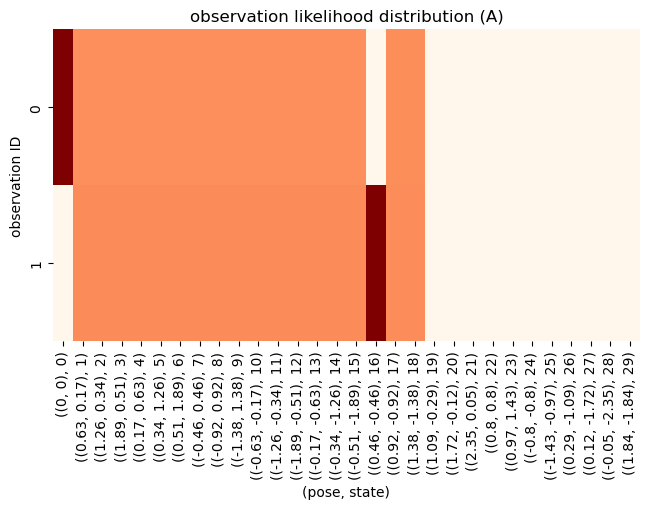

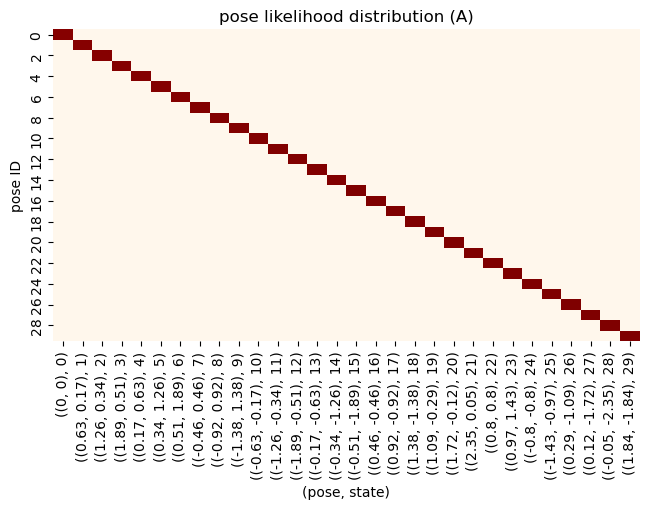

In [ ]:
A0 = plot_likelihood(ours.A[0], ours.agent_state_mapping, tittle_add='observation')
A1 = plot_likelihood(ours.A[1], ours.agent_state_mapping, tittle_add='pose')

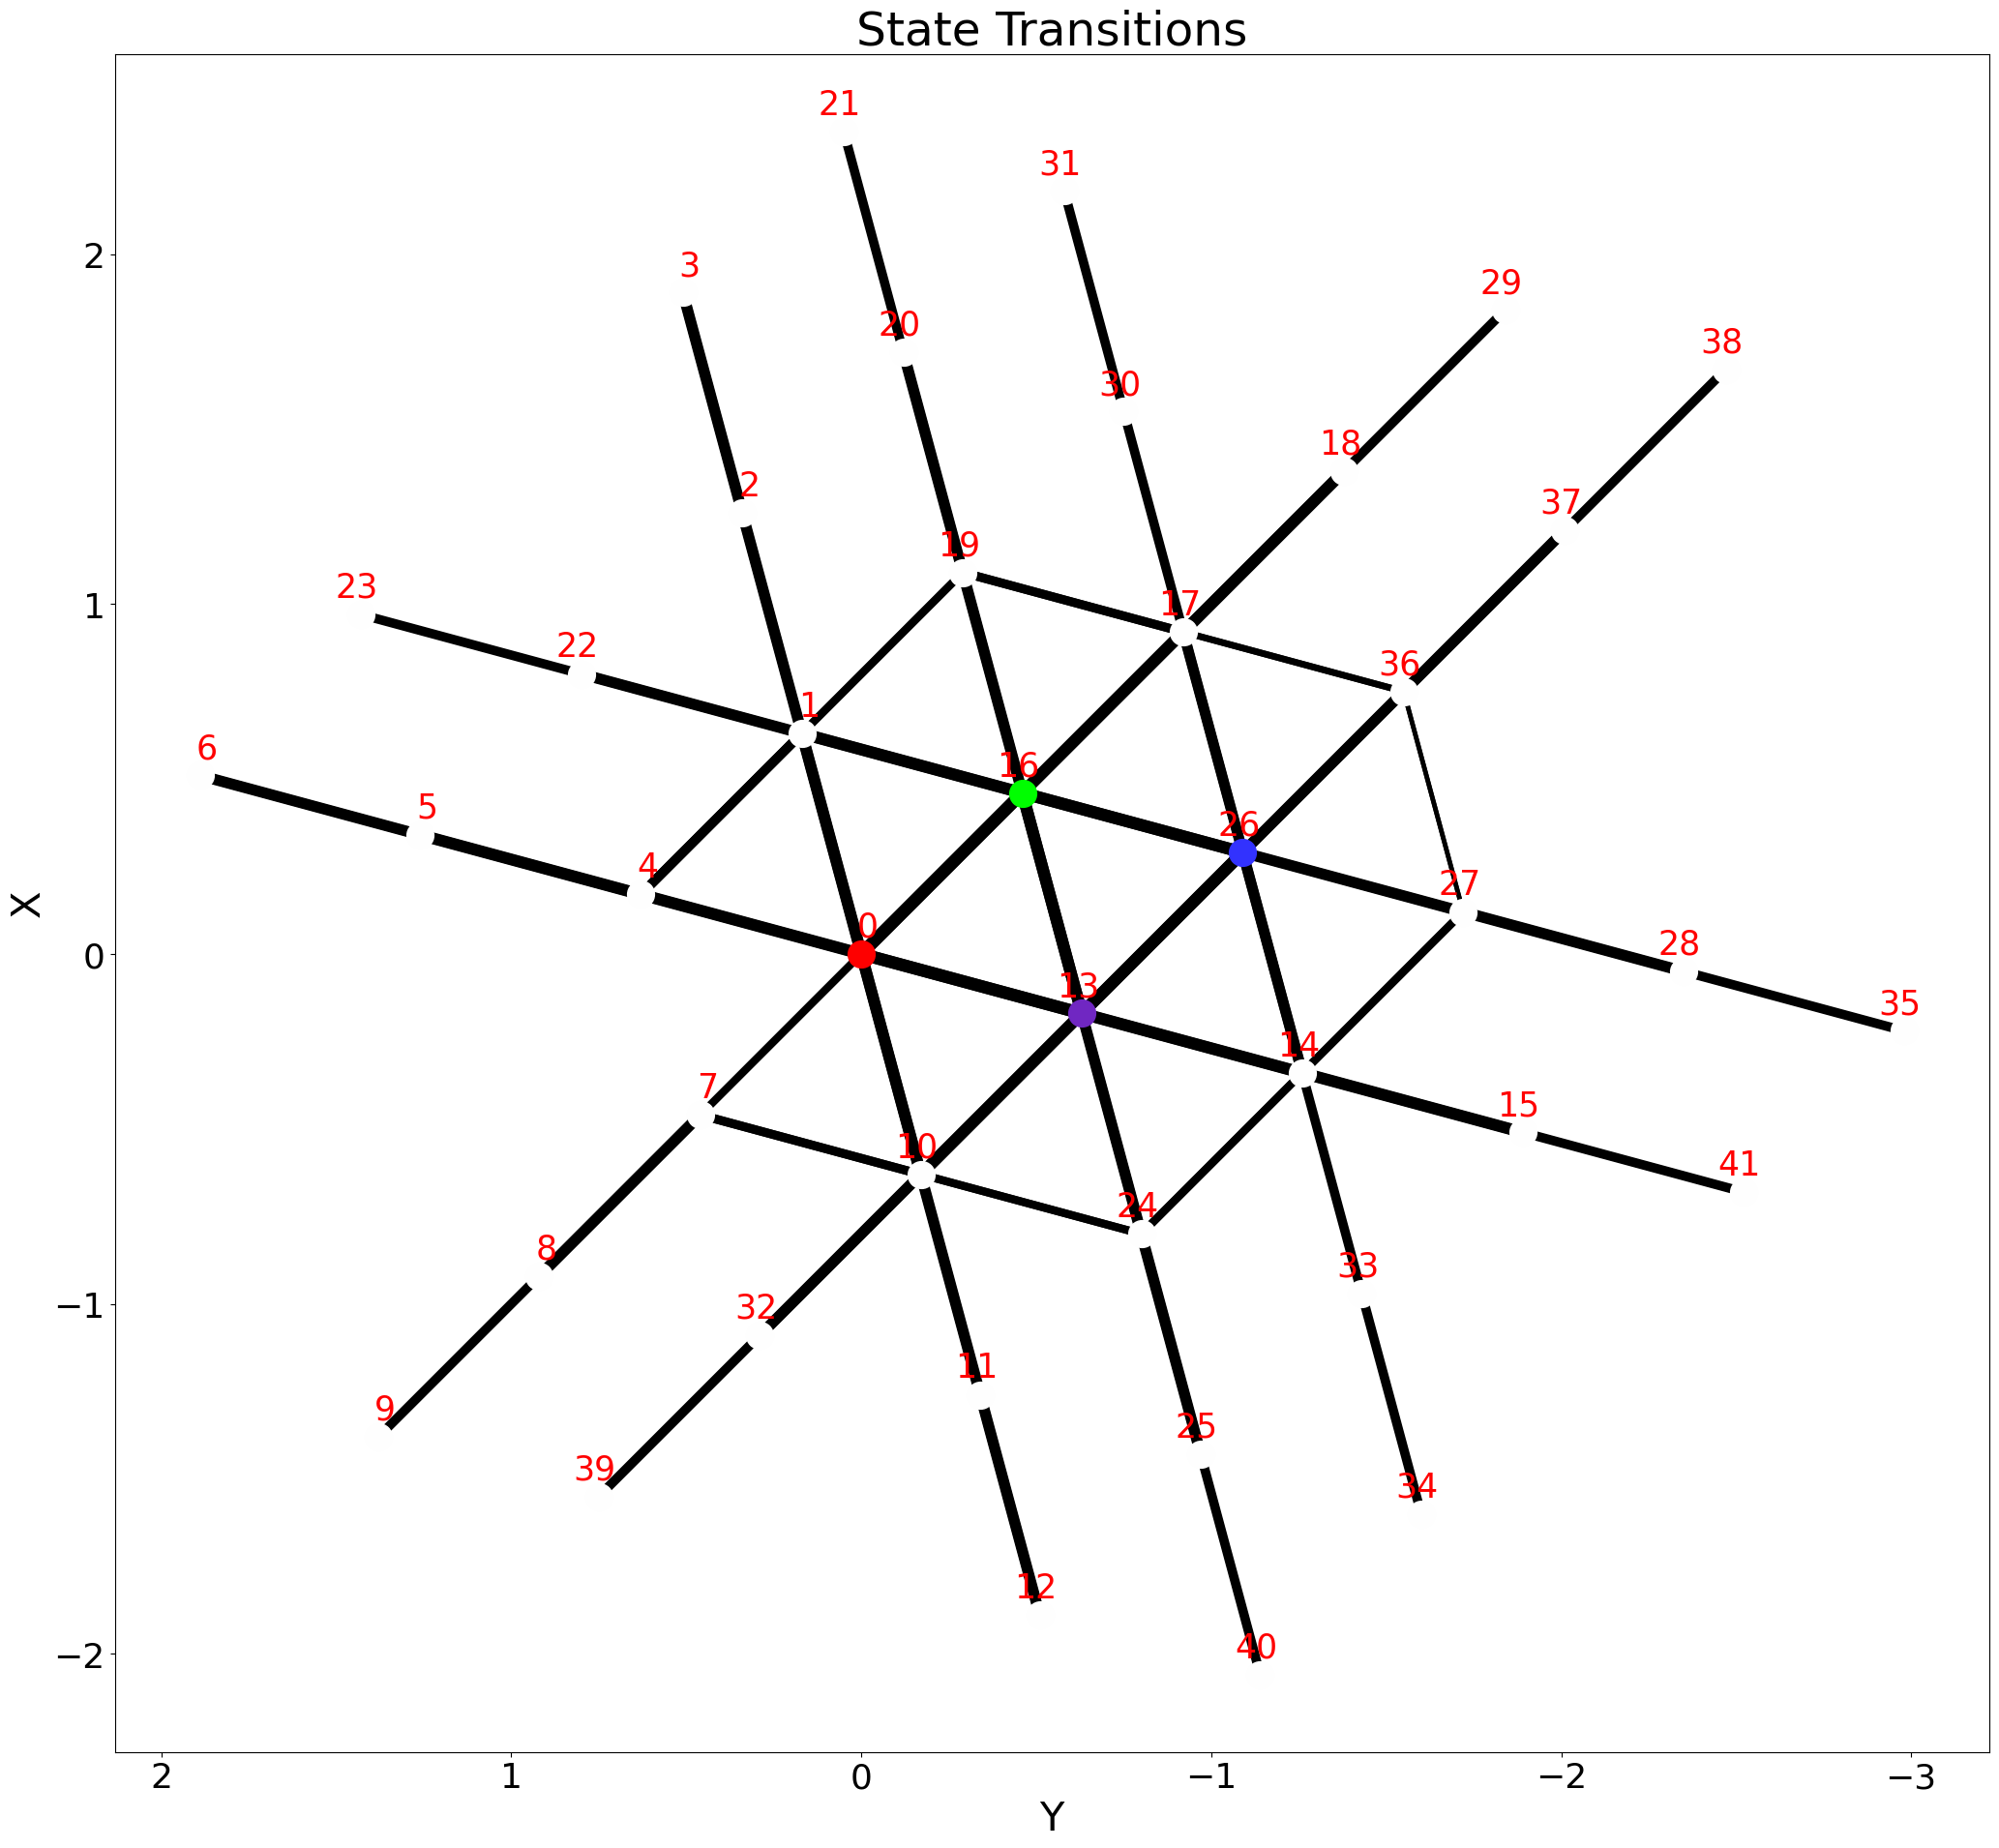

In [732]:
plot = plot_state_in_map(ours.B[0], ours.agent_state_mapping)

In [ ]:
print(ours.B[0][:,5,1])

In [ ]:
B_v1_test1_ob = ours.B[0][:]

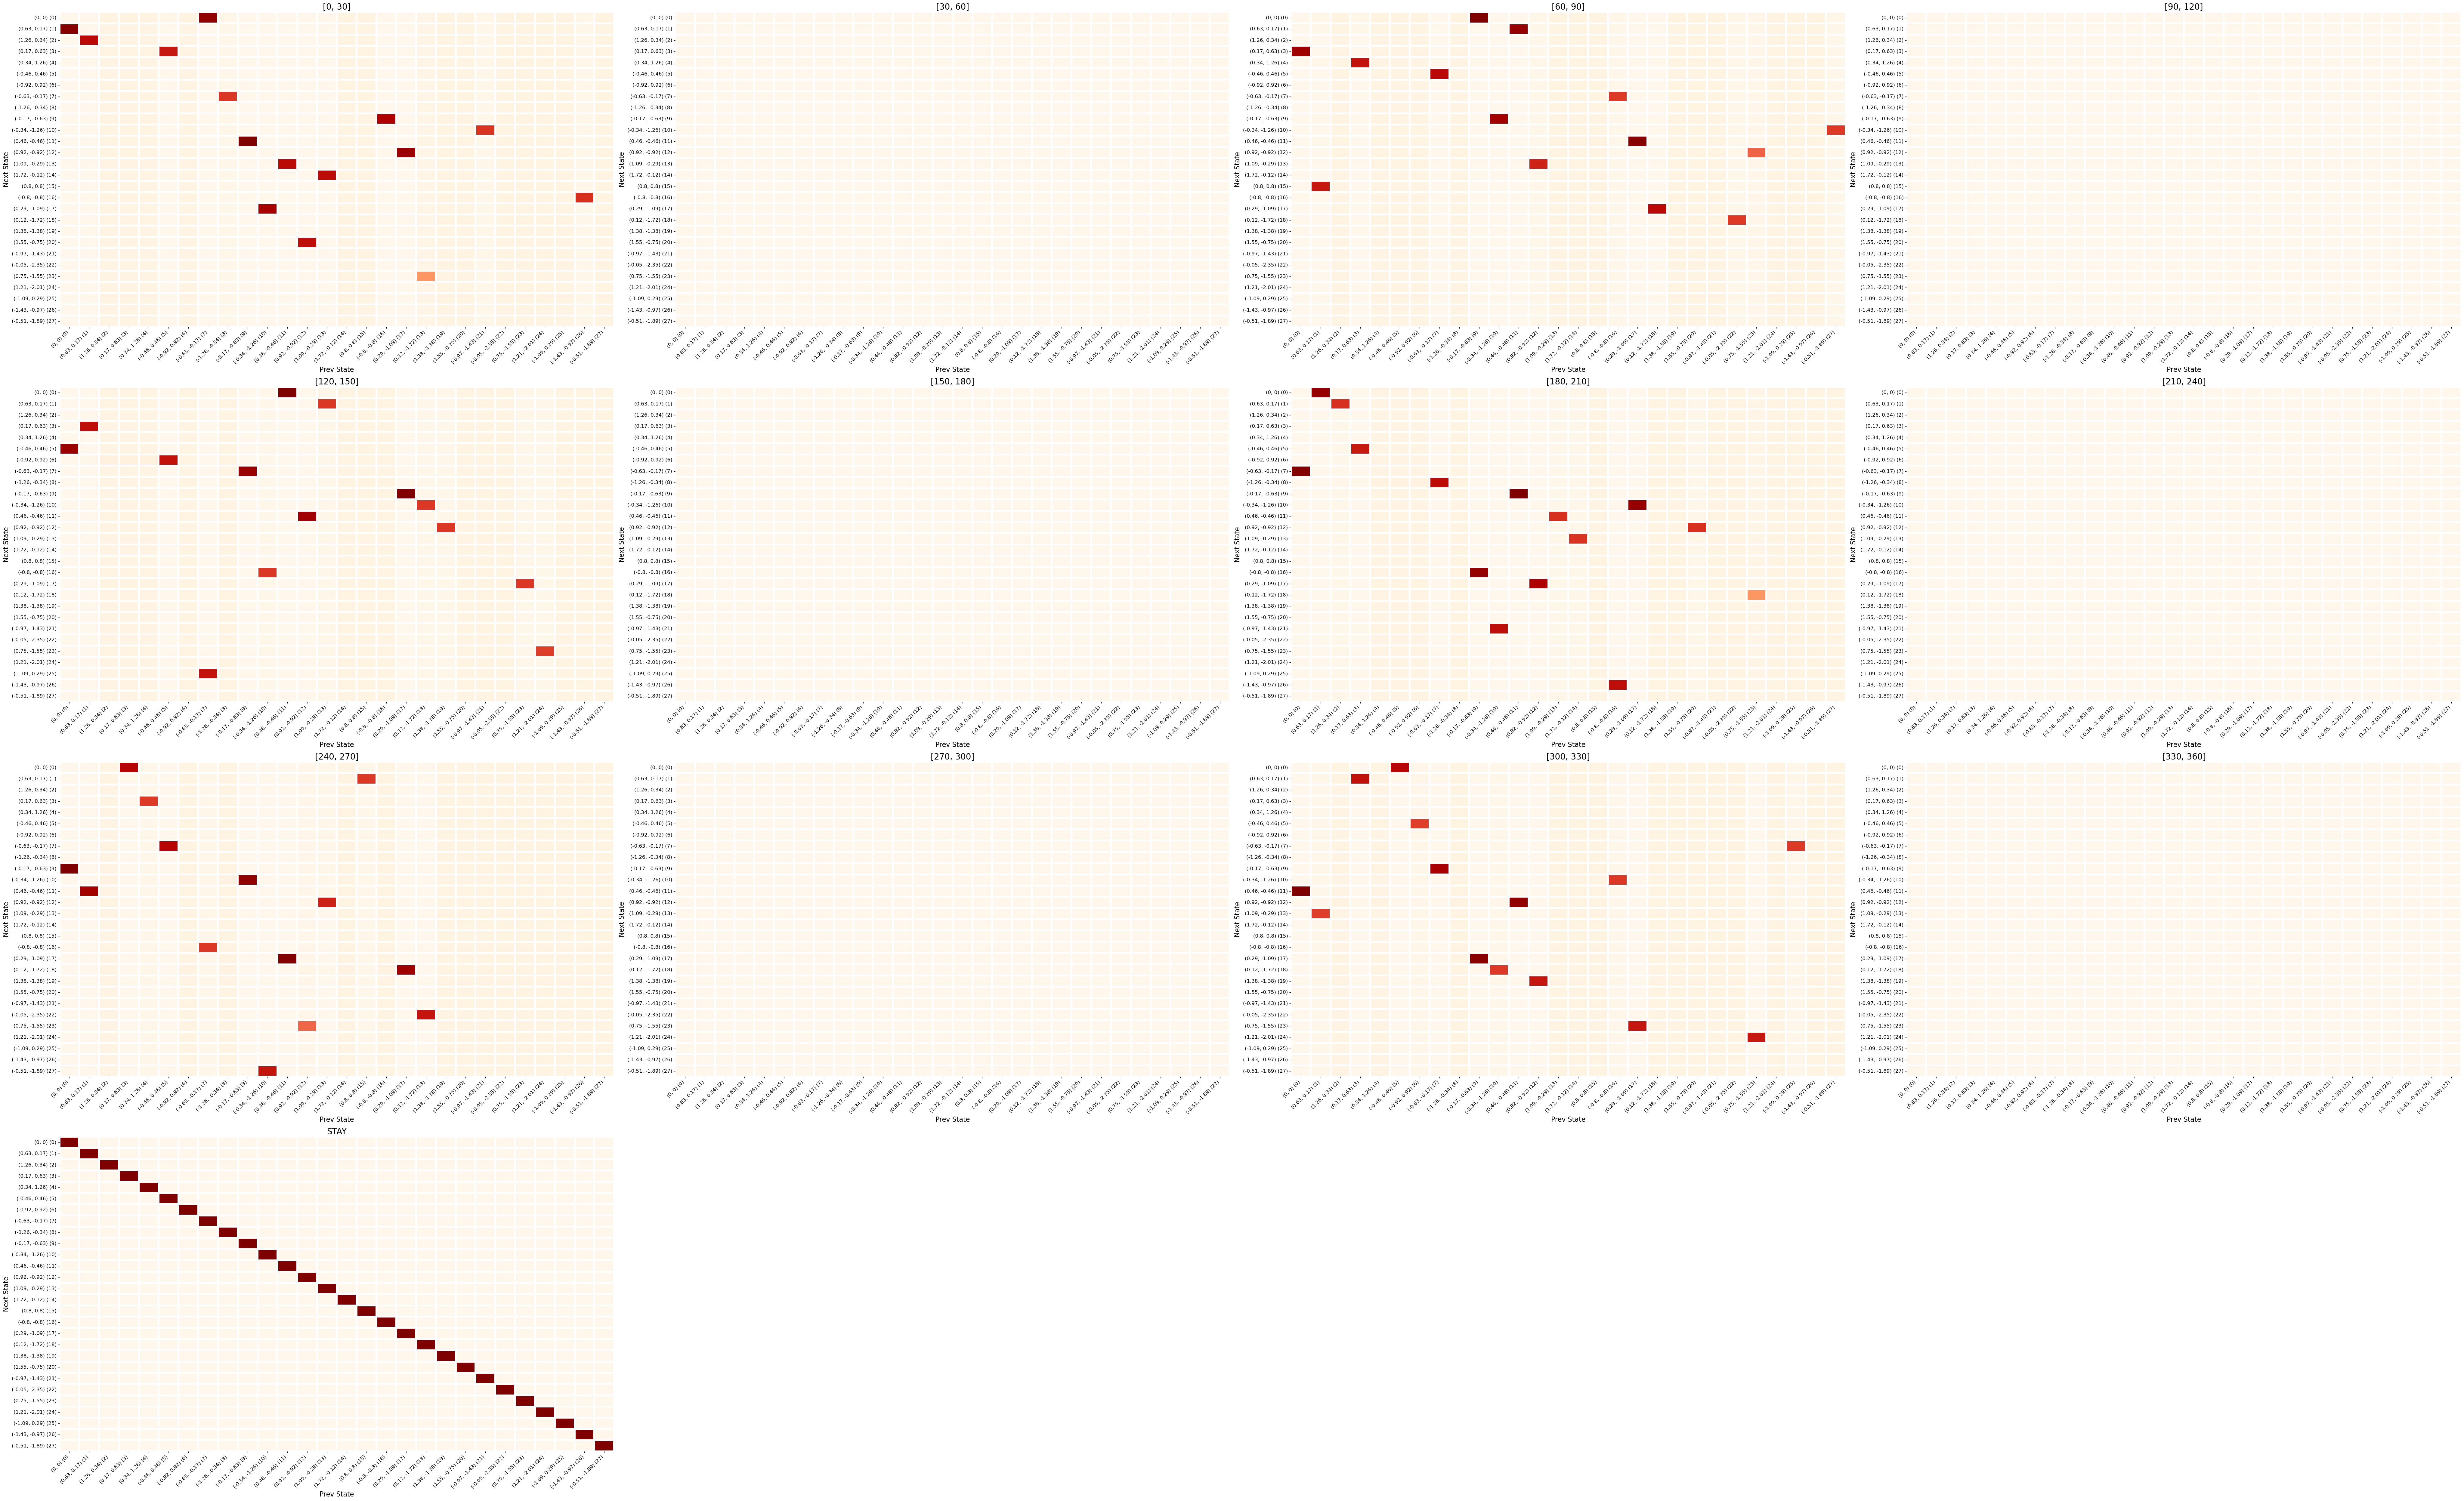

In [ ]:
B_plot = plot_transitions(ours.B[0], ours.agent_state_mapping, ours.possible_actions)

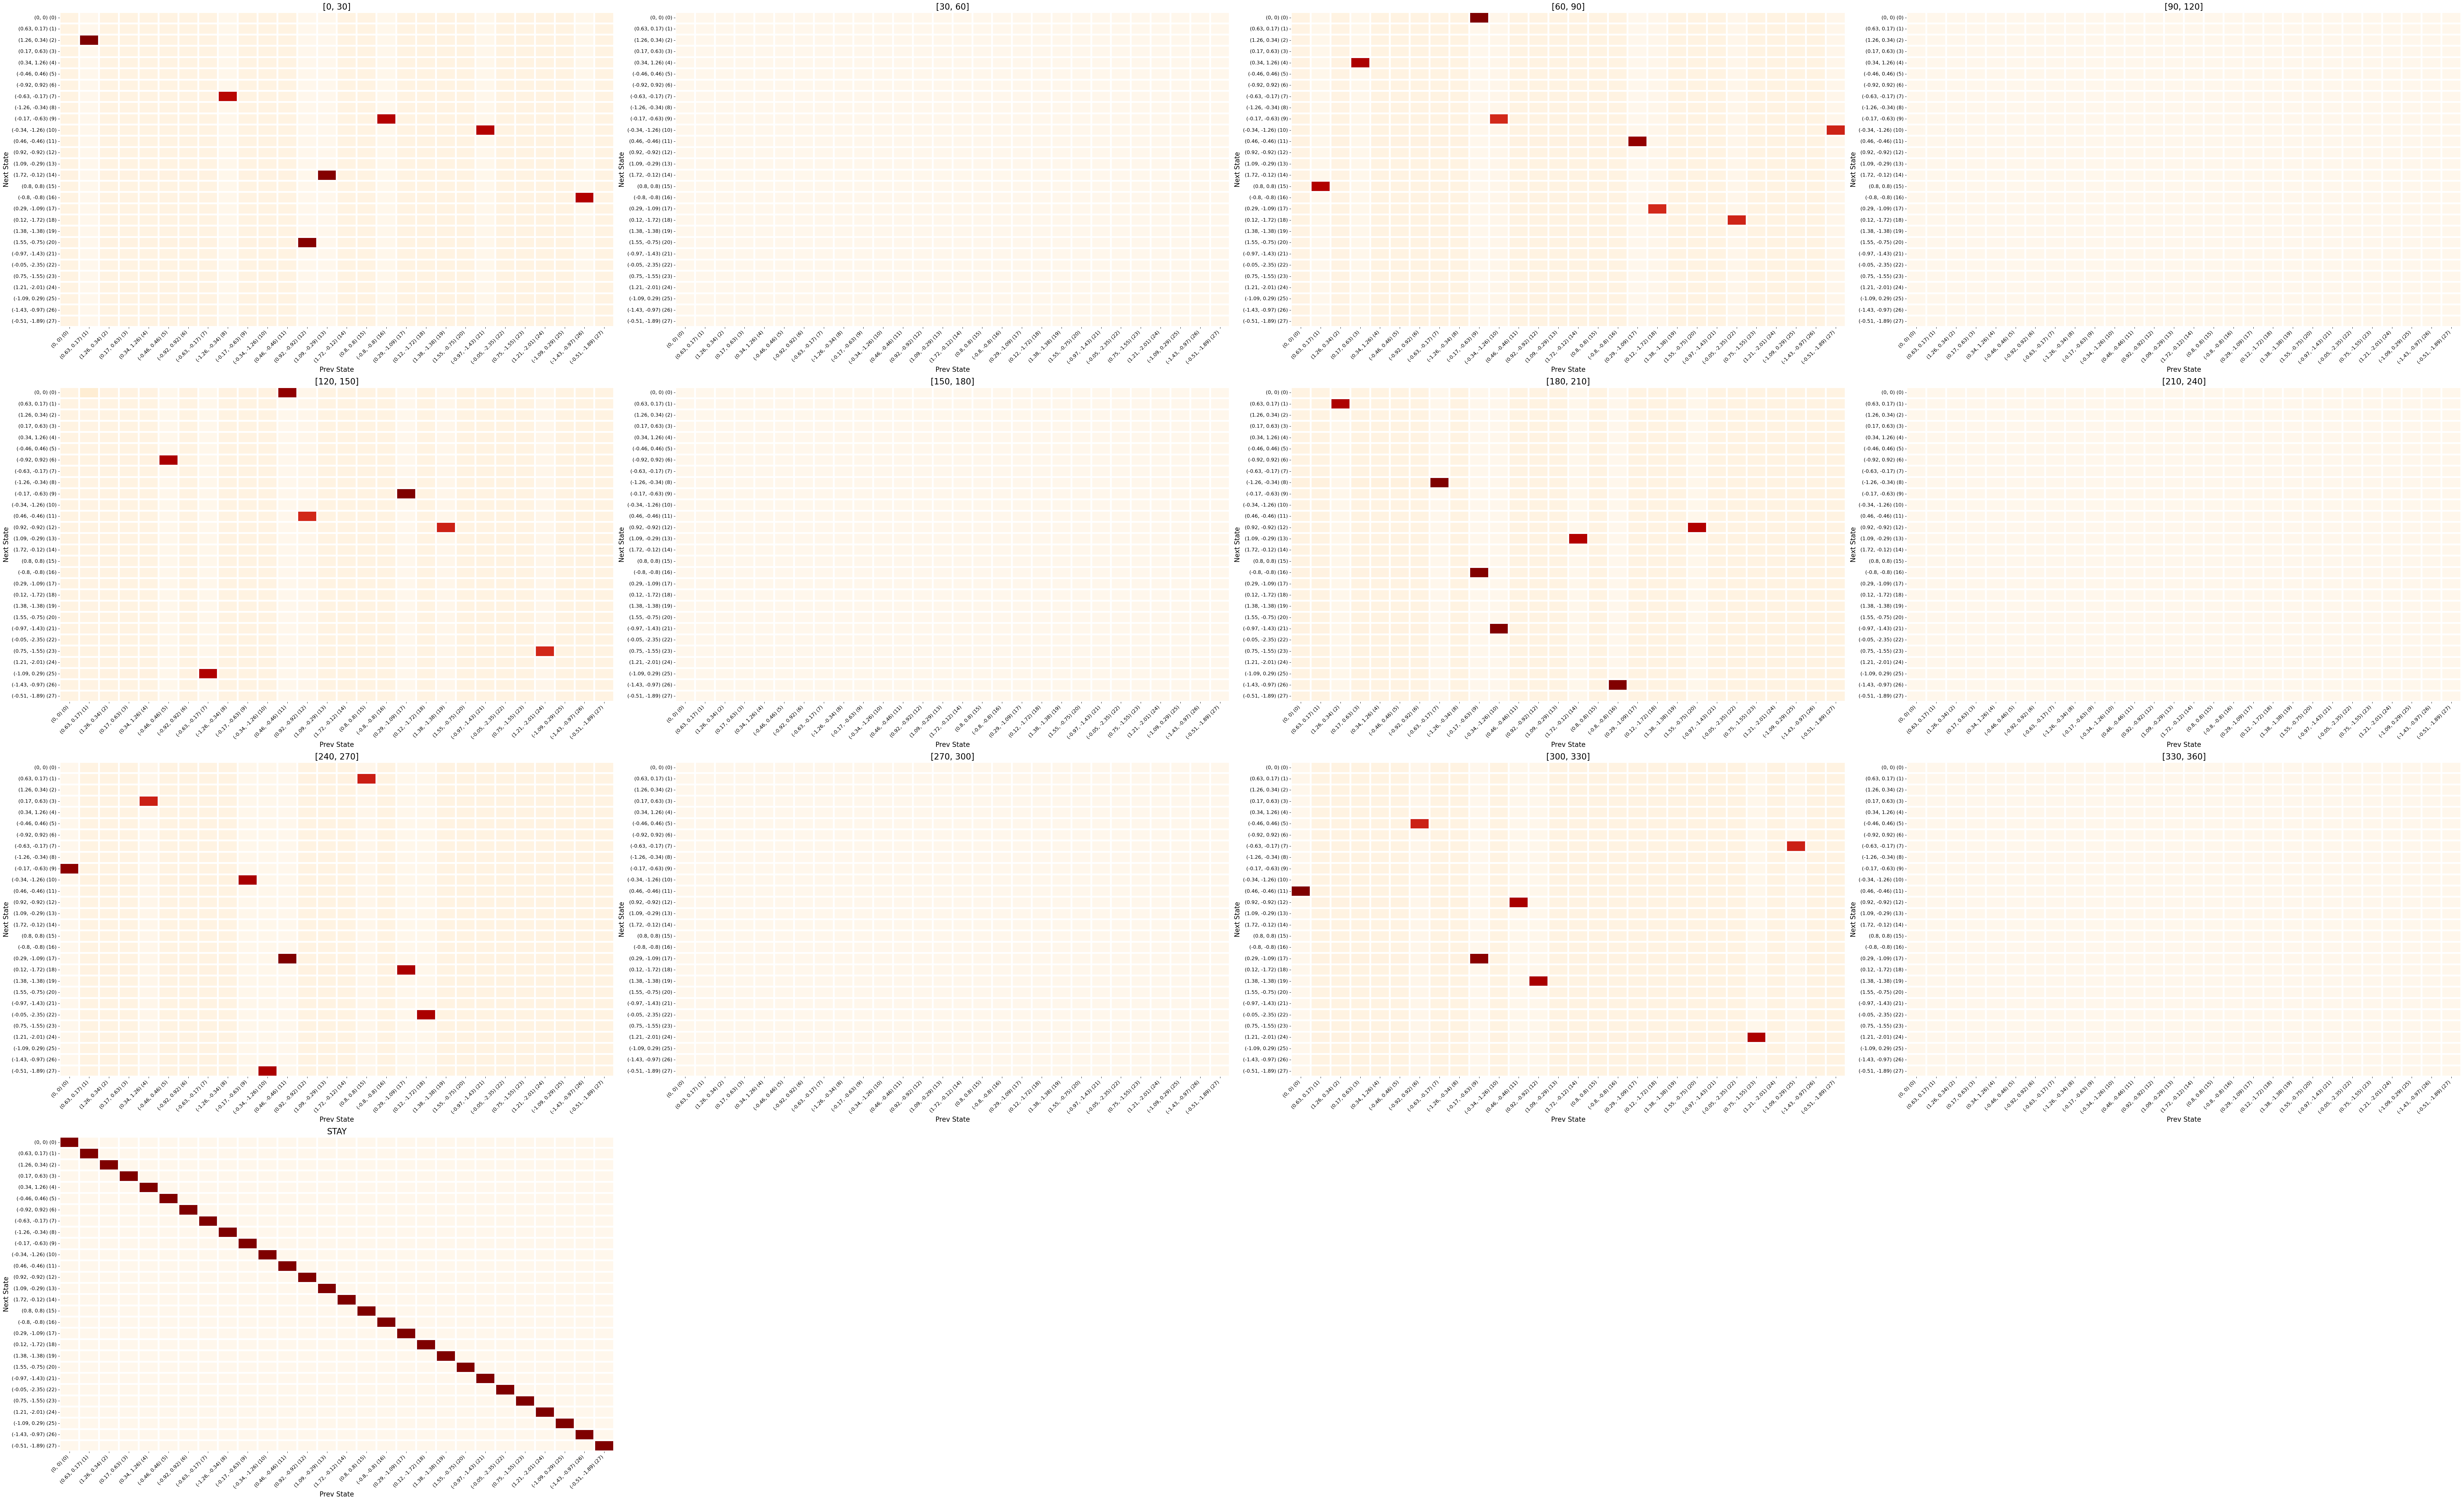

In [ ]:
B_plot = plot_transitions(ours.B[0], ours.agent_state_mapping, ours.possible_actions)

In [ ]:
B_plot_compare = compare_B1_B2_plots(B_v1_test1_ob, V_v1_test1_ob, ours.agent_state_mapping, ours.possible_actions)

# Random tests

In [ ]:
poses = ours.PoseMemory.poses
print(poses)
pose = poses[3]
for ref_p_idx, p in enumerate(poses):
    angle_p_to_pose = np.arctan2(pose[0], p[0]) - np.arctan2(pose[1], p[1])
    print(ref_p_idx, np.rad2deg(angle_p_to_pose))

    angle_p_to_pose = clip_rad_360(angle_p_to_pose)

    print(ref_p_idx, np.rad2deg(angle_p_to_pose))



In [ ]:
pose = (-0.63, 0.17)
p = [-0.63, -0.17]

euclidian_distance(pose, p)

Angles between poses

In [ ]:
pose = [0.56,0.15]
for ref_p_idx, p in enumerate(poses):
    # print(np.arctan2(pose[0], p[0]),np.arctan2(pose[1], p[1]))
    #angle between two points
    print('_')
    aangle_pose_to_p =np.arctan2(p[1]- pose[1], p[0]- pose[0])
    # aaangle_p_to_pose =clip_rad_360(np.arctan2(p[1]- 0, p[0]- 0))
    # print('angle_to_origin', np.rad2deg(aaangle_p_to_pose))
    aangle_pose_to_p = clip_rad_360(aangle_pose_to_p)
    #In reference to origin
    angle_pose_to_p = np.arctan2(p[1], p[0]) - np.arctan2(pose[1], pose[0])
#    angle_p_to_pose = np.arctan2(p[0], p[1]) - np.arctan2(pose[0], pose[1])

    angle_pose_to_p = clip_rad_360(angle_pose_to_p)
    dist_p_to_pose = euclidian_distance(pose, p)
    print(ref_p_idx, p,' to ', pose, 'angle', np.rad2deg(angle_pose_to_p), np.rad2deg(aangle_pose_to_p))


Point in polygons

In [ ]:
# Checking if a point is inside a polygon
def point_in_polygon(pt, polygon):
    num_vertices = len(polygon)
    inside = False
 
    # Store the first point in the polygon and initialize the second point
    p1 = polygon[0]
 
    # Loop through each edge in the polygon
    for i in range(1, num_vertices + 1):
        # Get the next point in the polygon
        p2 = polygon[i % num_vertices]
 
        # Check if the point is above the minimum y coordinate of the edge
        if pt[1] > min(p1[1], p2[1]):
            # Check if the point is below the maximum y coordinate of the edge
            if pt[1] <= max(p1[1], p2[1]):
                # Check if the point is to the left of the maximum x coordinate of the edge
                if pt[0] <= max(p1[0], p2[0]):
                    # Calculate the x-intersection of the line connecting the point to the edge
                    x_intersection = (pt[1] - p1[1]) * (p2[0] - p1[0]) / (p2[1] - p1[1]) + p1[0]
 
                    # Check if the point is on the same line as the edge or to the left of the x-intersection
                    if p1[0] == p2[0] or pt[0] <= x_intersection:
                        # Flip the inside flag
                        inside = not inside
 
        # Store the current point as the first point for the next iteration
        p1 = p2
 
    # Return the value of the inside flag
    return inside

POint in triangle

In [ ]:
import copy
def sign(p1, p2, p3):
    return (p1[0]- p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

def point_in_triangle(pt, triangle_poses):
    p1,p2,p3 = triangle_poses[0], triangle_poses[1], triangle_poses[2]
    d1 = sign(pt, p1, p2)
    d2 = sign(pt, p2, p3)
    d3 = sign(pt, p3, p1)
    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0) 
    return not (has_neg and has_pos)

odom = ours.PoseMemory.get_odom()
action_id = 0

zone_influence = ours.possible_actions[action_id][:]

triangle_poses = [odom]
print('odom', odom, 'IR', ours.influence_radius, 'ZI', zone_influence)
for angle_deg in zone_influence:
    angle_rad = np.deg2rad(angle_deg)
    x =2*ours.influence_radius * np.cos(angle_rad) + odom[0]
    y= 2*ours.influence_radius * np.sin(angle_rad) + odom[1]
    triangle_poses.append([x,y])
print('triangle_poses', triangle_poses)

point_in_triangle([0.5,0.25], triangle_poses)

# zone_influence = ours.possible_actions[action_id]
# max_dist_angle = (zone_influence[0] + zone_influence[1]) /2
# # not pretty but because Copy [:] etc is not really changing pointer...
# zone_influence = [zone_influence[0], max_dist_angle, zone_influence[1]]

# quadri_poses = [odom]
# print('odom', odom, 'IR', ours.influence_radius, 'ZI', zone_influence)
# for angle_deg in zone_influence:
#     angle_rad = np.deg2rad(angle_deg)
#     x =2*ours.influence_radius * np.cos(angle_rad) + odom[0]
#     y= 2*ours.influence_radius * np.sin(angle_rad) + odom[1]
#     quadri_poses.append([x,y])

# print(max_dist_angle,'quadri_poses', quadri_poses)

# point_in_polygon([0.5,0.25], quadri_poses)



In [ ]:
possible_actions = ours.possible_actions.copy()
possible_actions

In [ ]:
def pose_to_id(self, pose:list=None, odom:list=None, save_in_memory:bool = False) -> int:
        """
        return the position id from memory. 
        Evaluate if the given pose is in action range of other memorised poses 
        considering it's orientation difference and distance (<zone of influence)

        Parameters:
            pose (list): the pose we want to evaluate from memory
            save_in_memory (bool, optional): Do we want to save this pose in memory? 

        Returns:
            int: The pose id, -1 if none in memory and we don't want to remember this new pose
        """
        
        if pose is None:
            pose = self.odometry[:2]
        else:
            pose = pose[:2]

        if odom is None:
            odom = self.odometry[:2]
        else:
             odom = odom[:2]
        
        zone_action = self.possible_actions[0]
        p_idx = -1
        #TODO: CONSIDR ANGLE, ELSE WE Can'T HAVE 12 NODES IN SAME ZONE OF INF
        ref_closest_dist = self.influence_radius
        for ref_p_idx, p in enumerate(self.poses):
            print('_____')
            angle_pose_to_curr_pose = clip_rad_360(np.arctan2(pose[1]- odom[1], pose[0]- odom[0]))
            angle_p_to_curr_pose= clip_rad_360(np.arctan2(p[1]- odom[1], p[0]- odom[0])) 
            diff_angle =  abs(angle_pose_to_curr_pose -angle_p_to_curr_pose)
            # angle_ref_pose_to_origin = clip_rad_360(angle_ref_pose_to_origin)
            
            dist_p_to_pose = euclidian_distance(pose, p)
            print('ref idx and pose', ref_p_idx,p)
            print('angle pose to curr_pose', round(np.rad2deg(angle_pose_to_curr_pose),2), 'angle_p_to_curr_pose',round(np.rad2deg(angle_p_to_curr_pose),2),'dist', dist_p_to_pose)
            #If pose in the same action and influence zone
            #if abs(np.rad2deg(angle_p_to_pose)) <= np.mean(zone_action) and dist_p_to_pose < ref_closest_dist:
            if np.rad2deg(diff_angle) <= np.mean(zone_action) and dist_p_to_pose < ref_closest_dist:
                p_idx = ref_p_idx
                ref_closest_dist = dist_p_to_pose
                
        #No identified pose match current pose
        if p_idx < 0 and save_in_memory:
            pose = tuple(pose)
            self.poses.append(pose)
            p_idx = self.poses.index(pose)
        
        return p_idx

In [ ]:
def pose_transition_from_action(self,action:int, odom:list=None, ideal_dist:float=None):
        """
        Check if we have a pose in twice the area of the agen influence radius. 
        If we do, return this pose
        If we don't, we create a new node at a given ideal distance (if none given it's the influence radius + small value)
        """
        if odom is None:
            odom = self.odometry.copy()
        if self.possible_actions[action] == 'STAY':
            return odom
        
        zone_influence = self.possible_actions[action][:]
        triangle_poses = [odom]
        # print('odom', odom, 'IR', self.influence_radius, 'ZI', zone_influence)
        for angle_deg in zone_influence:
            angle_rad = np.deg2rad(angle_deg)
            x= 2*self.influence_radius * np.cos(angle_rad) + odom[0]
            y= 2*self.influence_radius * np.sin(angle_rad) + odom[1]
            triangle_poses.append([x,y])
        print('triangle_poses', triangle_poses)
        #check if pose in zone of action already exist in memory
        for pose in self.poses:
            pt_in_tr = point_in_triangle(pose[:2], triangle_poses)
            if pt_in_tr and not list(pose[:2]) == list(odom[:2]):
                return pose[:] #return corresponding pose
        if ideal_dist is None:
            ideal_dist = self.influence_radius + self.influence_radius/5 #just not be exactly on the radius
        average_angle = np.deg2rad(np.mean(zone_influence))
        x= ideal_dist * np.cos(average_angle) + odom[0]
        y= ideal_dist * np.sin(average_angle) + odom[1]
        return [x,y]

In [ ]:
triangles_poses = [[0.17, 0.97], [-0.3300000000000003, 0.10397459621556171], [0.16999999999999982, -0.030000000000000027]]
next_pose = [0.0, 0.0]
point_in_triangle(next_pose, triangle_poses)

In [ ]:
# next_pose = [0.97, 0.26]
# next_pose = [1.12, 0.0]
odom = [0.17, 0.97]
print(pose_transition_from_action(ours.PoseMemory, 8, odom=odom))
# print(pose_transition_from_action(ours.PoseMemory, 1, odom=odom))

# pose_to_id(ours.PoseMemory, next_pose, odom)

Point in triangle with arc

In [ ]:
def sign(p1, p2, p3):
    return (p1[0]- p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

def is_clokwise_from_p1_to_p2(p1:list, p2:list)->bool:
    ''' 
    Determines whether `p2` is in the **clockwise direction** from `p1`.

    This is done by projecting `p2` onto the **perpendicular normal** of `p1`. 
    If the projection is **negative**, `p2` is clockwise from `p1`, otherwise counterclockwise.

    Parameters:
        p1 (list or tuple): The first 2D point `[x1, y1]`
        p2 (list or tuple): The second 2D point `[x2, y2]`

    Returns:
        bool: `True` if `p2` is **clockwise** from `p1`, otherwise `False`
    '''
    #p1_n= [-p1[1],p1[0]] #counter clockwise normal
    pt_proj = -p1[0]*p2[1] + p1[1]*p2[0]
    return pt_proj < 0

def is_within_radius_range(pt:list, arc_radius:float)->bool:
    '''
    Checks if a point `pt` lies within a circular region **centered at the origin** 
    with the given `arc_radius`.

    Parameters:
        pt (list or tuple): The 2D point `[x, y]`
        arc_radius (float): The radius of the circular region

    Returns:
        bool: `True` if `pt` is **inside or on** the circle, otherwise `False`
    '''
    return pt[0]**2 + pt[1]**2 <= arc_radius**2

def point_in_triangle_with_arc(pt:list, polygon:list)-> bool:
    '''
    Determines if a point `pt` lies **inside a triangular region with one curved edge**.

    The **polygon** is expected to have **4 points**:
    - `[odom, start_vector, end_vector, arc_center]`
    - The **arc** is formed between `start_vector` and `end_vector`, centered at `arc_center`.

    **Steps:**
    1. Check if the point is inside the regular **triangle** formed by `odom, start_vector, end_vector`.
    2. If not, check if it's inside the **curved region**:
        - The point must be within the **circular range**.
        - The point must be **between** `start_vector` and `end_vector` in a clockwise sense.

    Parameters:
        pt (list or tuple): The 2D point `[x, y]` to check.
        polygon (list of lists): A list of **4 points** `[p0, p1, p2, arc_center]`.

    Returns:
        bool: `True` if `pt` is inside the **triangle-with-arc**, otherwise `False`.
    
    NOTE: the odom point will not be considered in triangle with arc
    '''
    arc_center = polygon.pop(2)
    arc_radius = euclidian_distance(polygon[0], arc_center) #should be influence_radius*2
    p1, p2 = polygon[1], polygon[2]

    # Check if inside the triangle
    if point_in_triangle(pt, polygon):
        print('In triangle')
        return True 

    
    # If p2 vector is clocwise from pt and pt is clocwise from p1
    #  and in the circular region, then it's in the zone
    if is_within_radius_range(pt, arc_radius) and \
    is_clokwise_from_p1_to_p2(pt,p2) and not is_clokwise_from_p1_to_p2(pt,p1):
       return True

    return False 



In [ ]:
def quadrilater_points(self, action, odom):
    zone_influence = self.possible_actions[action][:]
    quadri_poses = [odom]
 
    max_dist_angle = (zone_influence[0] + zone_influence[1]) /2
    # not pretty but because Copy [:] etc is not really changing pointer...
    zone_influence = [zone_influence[0], max_dist_angle, zone_influence[1]]
    
    for angle_deg in zone_influence:
        angle_rad = np.deg2rad(angle_deg)
        x =2*self.influence_radius * np.cos(angle_rad) + odom[0]
        y= 2*self.influence_radius * np.sin(angle_rad) + odom[1]
        quadri_poses.append([x,y])

    return quadri_poses
        
def pose_transition_from_action(self,action:int, odom:list=None, ideal_dist:float=None):
    """
    Check if we have a pose in twice the area of the agen influence radius. 
    If we do, return this pose
    If we don't, we create a new node at a given ideal distance (if none given it's the influence radius + small value)
    """
    if odom is None:
        odom = self.odometry.copy()
    if self.possible_actions[action] == 'STAY':
        return odom
    
    
    polygon = quadrilater_points(self,odom)
    print('odom', odom, 'IR', self.influence_radius, 'ZI', zone_influence)
    
    #check if pose in zone of action already exist in memory
    for pose in self.poses:
        pt_in_tr = point_in_triangle(pose[:2], polygon)
        print('pt in polygon?', pt_in_tr)
        if pt_in_tr and not list(pose[:2]) == list(odom[:2]):
            return pose[:] #return corresponding pose
    if ideal_dist is None:
        ideal_dist = self.influence_radius + self.influence_radius/5 #just not be exactly on the radius
    average_angle = np.deg2rad(np.mean(polygon))
    x= ideal_dist * np.cos(average_angle) + odom[0]
    y= ideal_dist * np.sin(average_angle) + odom[1]
    return [x,y]


In [ ]:

# pop_elem = quadri.pop(2)

# euclidian_distance(pop_elem, odom)
# print(quadri, pop_elem)

check point assignement

In [ ]:
def point_in_triangle_with_arc(pt:list, quadri_poses:list)-> bool:
    '''
    Determines if a point `pt` lies **inside a triangular region with one curved edge**.

    The **polygon** is expected to have **4 points**:
    - `[odom, start_vector, end_vector, arc_center]`
    - The **arc** is formed between `start_vector` and `end_vector`, centered at `arc_center`.

    **Steps:**
    1. Check if the point is inside the regular **triangle** formed by `odom, start_vector, end_vector`.
    2. If not, check if it's inside the **curved region**:
        - The point must be within the **circular range**.
        - The point must be **between** `start_vector` and `end_vector` in a clockwise sense.

    Parameters:
        pt (list or tuple): The 2D point `[x, y]` to check.
        polygon (list of lists): A list of **4 points** `[p0, p1, p2, arc_center]`.

    Returns:
        bool: `True` if `pt` is inside the **triangle-with-arc**, otherwise `False`.
    
    '''
    polygon = quadri_poses[:]
    arc_point = polygon.pop(2)
    arc_radius = euclidian_distance(polygon[0], arc_point) #should be influence_radius*2
    p1, p2 = polygon[1], polygon[2]
    # print('polygon', polygon)
    # Check if inside the triangle
    if point_in_triangle(pt, polygon):
        # print(pt,'In triangle')
        # return True 
        pass

    print('<rad', is_within_radius_range(pt, polygon[0], arc_radius), ' pt to p2 clockwise',
    is_clokwise_from_p1_to_p2(pt,p2),  ' pt to p1 NOT clockwise', not is_clokwise_from_p1_to_p2(pt,p1))
    
    pt_between_vectors(pt, polygon[0], p1, p2)
    
    # If p2 vector is clocwise from pt and pt is clocwise from p1
    #  and in the circular region, then it's in the zone
    if is_within_radius_range(pt, polygon[0], arc_radius) :
       print(pt,'In arc')
    #    return True

    return False 

def pt_between_vectors(pt, odom, p1, p2):
    angle1 = clip_rad_360(np.arctan2(p1[1]-odom[1], p1[0]-odom[0]))
    angle2 = clip_rad_360(np.arctan2(p2[1]-odom[1], p2[0]-odom[0]))
    angle = clip_rad_360(np.arctan2(pt[1]-odom[1], pt[0]-odom[0]))
    return angle1 <= angle <= angle2
    # print(round(angle1,2) ,'<=', round(angle,2), '<=',round(angle2,2))
    # print( angle1 <= angle <= angle2)

In [ ]:
def pose_transition_from_actionn(self,action:int, odom:list=None, ideal_dist:float=None):
        """
        Check if we have a pose in twice the area of the agen influence radius. 
        If we do, return this pose
        If we don't, we create a new node at a given ideal distance (if none given it's the influence radius + small value)
        """
        if odom is None:
            odom = self.odometry.copy()
        if self.possible_actions[action] == 'STAY':
            return odom
        
        zone_influence = self.possible_actions[action][:]
        quadri = quadrilater_points(odom=odom, zone_influence=zone_influence,\
                                     influence_radius= self.influence_radius)
        
        print('quadri',quadri)
        x = []
        y = []
        for i in quadri:
             x.append(i[0])
             y.append(i[1])


        print(x, y)
        #check if pose in zone of action already exist in memory
        for i, pose in enumerate(self.poses):
            print('_') 
            print(i, 'pose',pose)
            pt_in_tr = point_in_triangle_with_arc(pose[:2], quadri)
            print('pt_in_tr', pt_in_tr)
            if pt_in_tr and not list(pose[:2]) == list(odom[:2]):
                return pose[:] #return corresponding pose
        print('no good point')
        if ideal_dist is None:
            ideal_dist = self.influence_radius + self.influence_radius/5 #just not be exactly on the radius
        average_angle = np.deg2rad(np.mean(zone_influence))
        x= ideal_dist * np.cos(average_angle) + odom[0]
        y= ideal_dist * np.sin(average_angle) + odom[1]
        return [x,y]

In [ ]:
def determine_next_pose(self, odom, action_id, min_dist_to_next_node):
        next_pose = pose_transition_from_actionn(self.PoseMemory, action =action_id, odom= odom, ideal_dist=min_dist_to_next_node)
        next_pose = [round(elem, 2) for elem in next_pose]
        next_pose_id = self.PoseMemory.pose_to_id(next_pose, save_in_memory=False)
        print('action, next pose and id', action_id, next_pose, next_pose_id)
        return next_pose, next_pose_id


In [ ]:
action_adjacent = 7
odom = [0.29, -1.09]
pt = [0.10,0.10]
next_adjacent_pose, next_adjacent_pose_id = determine_next_pose(ours, odom, \
                                                                action_adjacent, 0.65)

print(next_adjacent_pose)

# quadri = quadrilater_points(odom=odom, zone_influence=zone_influence,\
#                                      influence_radius= 0.5)
# quadri = quadrilater_points(ours.PoseMemory,  0, odom=odom)
# point_in_triangle_with_arc(pt, quadri)

In [ ]:
quadri = [[0.29, -1.09], [-0.5760254037844386, -1.5900000000000003], [-0.4171067811865477, -1.7971067811865475], [-0.21000000000000035, -1.9560254037844382]]
pt = (0.1, -1.4)
odom = (0.29, -1.09)

point_in_triangle_with_arc(pt, quadri)

In [ ]:
330.0 <= 15.1 <= 0.0